# Задача "Прогноз состава сырья"

## Описание задачи
На нефтехимические заводы СИБУР сырье (широкая фракция легких углеводородов - ШФЛУ) поступает по трубопроводу. Трубопровод наполняется на нескольких станциях подкачки, которые расположены последовательно на пути к потребителю.

Состав ШФЛУ меняется на каждой станции с течением времени и, таким образом, меняется итоговый состав ШФЛУ, которую получает потребитель. Имея достоверный прогноз по составу можно оптимизировать некоторые технологические процессы.

Вам предстоит построить прогноз состава поступающей по трубопроводу ШФЛУ на основании данных с последней перед потребителем станции подкачки. При этом геометрия трубопровода, расстояние от станции подкачки до потребителя и другие параметры трубопровода не раскрываются.

Метрикой в этой задаче служит средняя по всем целевым переменным MAPE.

## Данные
Данные содержат расходы сырья в т/ч для станции подкачки A (A_rate) и потребителя B (B_rate), а также массовые процентные доли различных компонент на станции A (A_CH4, A_C2H6, A_C3H8, A_iC4H10, A_nC4H10, A_iC5H12, A_nC5H12, A_C6H14).

Целевые переменные: массовые процентные доли нескольких компонент на станции B (B_C2H6, B_C3H8, B_iC4H10, B_nC4H10). Целевые переменные для тестового периода не содержат разрывов, поэтому загружаемое решение должно содержать все временные метки из тестового множества.

train_targets.csv - целевые переменные для тренировочного множества
train_features.csv - признаки для тренировочного множества
test_features.csv - признаки для тестового множества
sample_submission.csv - пример решения в правильном формате

## Вебинар
На вебинаре организаторы разъяснили немного условия задачи.
Есть трубопровод по которому подается ШФЛУ из сечения А в сечение В. По пути из А в В присутствует подкачка ШФЛУ более-менее стабильного состава. Расход данной подкачки можно определить на основании данных в условии задачи расходов в А и В.

G - массовый расход ШФЛУ, х - процентный массовый состав ШФЛУ по каждому компоненту

<center>
<img src="Schem.jpg">

Первое что приходит в голову - задача на **структуру потоков**.

Если бы были данные по устройству трубопровода (геометрия, топология, арматура), температура и давление ШФЛУ, результаты гидродинамических испытаний по структуре потока (кривые распределения времени пребывания, плотности распределения, кривые отклика) можно было бы попытаться создать модель (ячеечную или диффузионную), а также попробовать её решить численно, либо создать гибридную модель. Но данных таких нет и не всегда они бывают даже у датасайнтистов из Сибура...
    
    
Кстати, в интернете нашел интересную статью как раз по моделированию смешения и коэффициента продольного перемешивания (эффективная диффузия) - "*Новый метод расчета многопродуктовых магистральных
трубопроводов*", А.С. Дидковская

## Посмотрим на данные

In [143]:
import numpy as np
import pandas as pd
import seaborn as sns
import math as m

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
%matplotlib inline

In [144]:
import warnings
warnings.filterwarnings('ignore')

In [145]:
train_features = pd.read_csv('train_features.csv', header = 0, sep = ',')
test_features = pd.read_csv('test_features.csv', header = 0, sep = ',')
train_target = pd.read_csv('train_targets.csv', header = 0, sep = ',')

In [146]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [147]:
train_features[:]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 00:00:00  70.855017       NaN       NaN        NaN   
1     2020-01-01 00:30:00  70.826582       NaN       NaN        NaN   
2     2020-01-01 01:00:00  70.809637       NaN       NaN        NaN   
3     2020-01-01 01:30:00  69.994748       NaN       NaN        NaN   
4     2020-01-01 02:00:00  70.072762       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5803  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5804  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5805  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5806  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5807  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0           NaN        NaN       NaN       NaN       NaN  71.982789  
1           NaN        NaN       NaN       NaN       NaN  71.965098  
2           NaN        NaN       NaN       NaN       NaN  71.867409  
3           NaN        NaN       NaN       NaN       NaN  71.839126  
4           NaN        NaN       NaN       NaN       NaN  71.336921  
...         ...        ...       ...       ...       ...        ...  
5803  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  
5804  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  
5805  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  
5806  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  
5807  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  

[5808 rows x 11 columns]

In [148]:
train_features.corr()

A_rate     A_CH4    A_C2H6    A_C3H8  A_iC4H10  A_nC4H10  \
A_rate    1.000000  0.140528  0.437019  0.418836  0.017336 -0.430159   
A_CH4     0.140528  1.000000  0.335366  0.200776 -0.154180 -0.337805   
A_C2H6    0.437019  0.335366  1.000000  0.527549 -0.100987 -0.701938   
A_C3H8    0.418836  0.200776  0.527549  1.000000  0.486148 -0.709767   
A_iC4H10  0.017336 -0.154180 -0.100987  0.486148  1.000000  0.199295   
A_nC4H10 -0.430159 -0.337805 -0.701938 -0.709767  0.199295  1.000000   
A_iC5H12 -0.399400 -0.150923 -0.514814 -0.940113 -0.645688  0.546690   
A_nC5H12 -0.367528 -0.155106 -0.540416 -0.930008 -0.659884  0.523956   
A_C6H14  -0.318311 -0.128191 -0.407348 -0.881589 -0.686246  0.384840   
B_rate    0.962491  0.051154  0.341268  0.231222 -0.167036 -0.273329   

          A_iC5H12  A_nC5H12   A_C6H14    B_rate  
A_rate   -0.399400 -0.367528 -0.318311  0.962491  
A_CH4    -0.150923 -0.155106 -0.128191  0.051154  
A_C2H6   -0.514814 -0.540416 -0.407348  0.341268  
A_C3H8   -0.940113 -0.930008 -0.881589  0.231222  
A_iC4H10 -0.645688 -0.659884 -0.686246 -0.167036  
A_nC4H10  0.546690  0.523956  0.384840 -0.273329  
A_iC5H12  1.000000  0.975426  0.862518 -0.224065  
A_nC5H12  0.975426  1.000000  0.877563 -0.178315  
A_C6H14   0.862518  0.877563  1.000000 -0.122962  
B_rate   -0.224065 -0.178315 -0.122962  1.000000

In [149]:
train_features.describe()

A_rate        A_CH4       A_C2H6       A_C3H8     A_iC4H10  \
count  5807.000000  4849.000000  4849.000000  4849.000000  4849.000000   
mean     59.346948     0.159890     4.290739    37.990406    17.343168   
std      20.684895     0.068488     0.912565     3.756424     0.754301   
min       0.000321     0.008045     0.280524    11.345740    11.143152   
25%      61.846908     0.109331     3.971011    37.647968    17.018272   
50%      67.010148     0.139924     4.485758    38.618187    17.327200   
75%      69.734038     0.212163     4.844390    39.402360    17.685803   
max      74.560399     0.471429     6.418897    42.860283    20.353500   

          A_nC4H10     A_iC5H12     A_nC5H12      A_C6H14       B_rate  
count  4849.000000  4849.000000  4849.000000  4849.000000  5675.000000  
mean     24.413897     4.948636     4.809805     5.995740    64.817202  
std       1.274795     1.230539     1.285549     1.543956    10.696414  
min      18.655932     3.033678     1.338103     2.924722     0.000000  
25%      23.746663     4.462670     4.353103     5.574106    63.852030  
50%      24.138643     4.684908     4.619459     5.708216    68.583359  
75%      24.615843     5.086816     4.925770     6.032535    71.171153  
max      35.498867    13.812560    14.845480    30.656385    89.958390

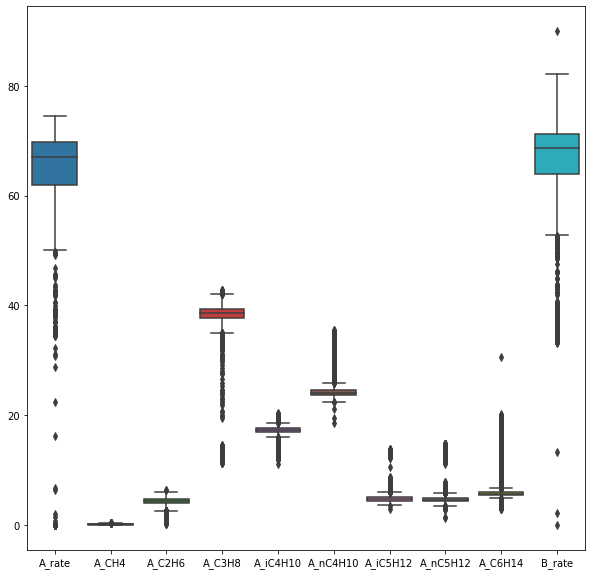

In [150]:
plt.rcParams["figure.figsize"] = (10,10)
sns.boxplot(data=train_features)

In [151]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [152]:
train_features.info()
train_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 11 columns):
timestamp    5808 non-null object
A_rate       5807 non-null float64
A_CH4        4849 non-null float64
A_C2H6       4849 non-null float64
A_C3H8       4849 non-null float64
A_iC4H10     4849 non-null float64
A_nC4H10     4849 non-null float64
A_iC5H12     4849 non-null float64
A_nC5H12     4849 non-null float64
A_C6H14      4849 non-null float64
B_rate       5675 non-null float64
dtypes: float64(10), object(1)
memory usage: 499.2+ KB


(5808, 11)

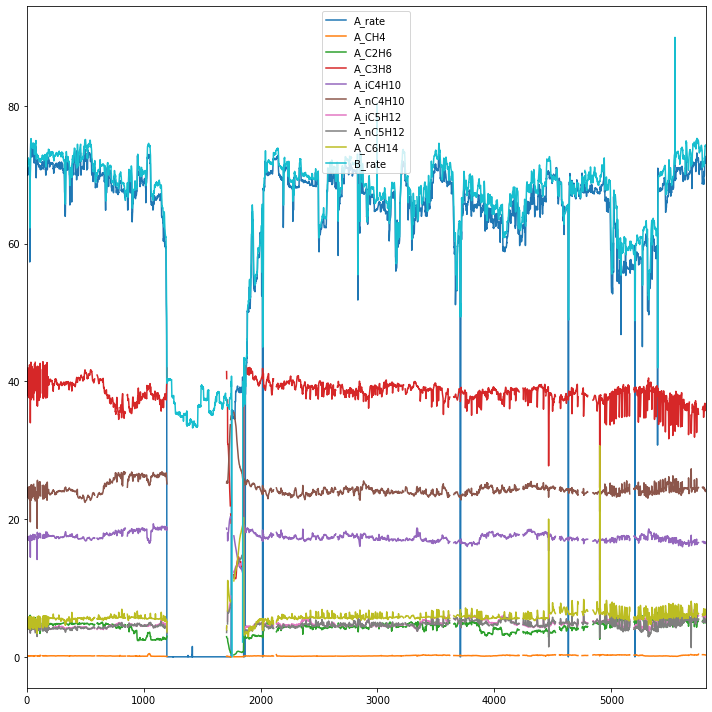

In [153]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [154]:
train_features[train_features["A_rate"] <= 40]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
1197  2020-01-25 22:30:00  37.634787  0.068959  2.783333  39.613317   
1198  2020-01-25 23:00:00   0.001294  0.070249  2.903388  41.168760   
1199  2020-01-25 23:30:00   0.001701  0.071737  2.994731  41.935570   
1200  2020-01-26 00:00:00   0.001525       NaN       NaN        NaN   
1201  2020-01-26 00:30:00   0.001055       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5201  2020-04-18 08:30:00  39.827838  0.240746  5.309529  38.752616   
5202  2020-04-18 09:00:00   0.002014  0.247586  5.250514  38.680070   
5203  2020-04-18 09:30:00   0.001633  0.261290  4.818443  38.907820   
5204  2020-04-18 10:00:00  38.215334  0.276025  4.567278  38.848842   
5396  2020-04-22 10:00:00  30.749718  0.110907  5.681407  38.414870   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
1197  18.374810  25.521723  4.473425  3.987337  5.163005  45.833590  
1198  18.650220  25.298560  4.232059  3.601516  4.062176  42.446206  
1199  18.765710  25.119170  4.089573  3.390231  3.620386  39.727496  
1200        NaN        NaN       NaN       NaN       NaN  39.972873  
1201        NaN        NaN       NaN       NaN       NaN  40.089745  
...         ...        ...       ...       ...       ...        ...  
5201  17.415626  24.286268  4.272327  4.035304  5.629434  56.099281  
5202  17.369883  24.286207  4.326687  4.089799  5.691831  48.813637  
5203  17.416410  24.441860  4.462670  4.187992  5.451690  49.964670  
5204  17.454773  24.491840  4.555090  4.260572  5.496899  48.964665  
5396  17.581315  24.102620  4.432917  3.888675  5.740080  54.846246  

[694 rows x 11 columns]

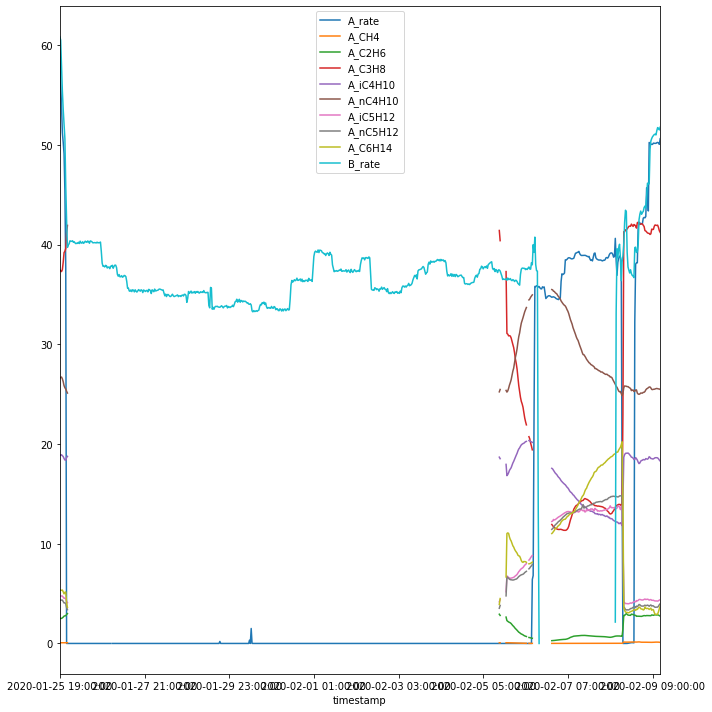

In [155]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[1190:1900].plot('timestamp')

# make room for tick labels
plt.tight_layout()


plt.show()

In [156]:
#drop_list = [i for i in range(1190,1900)]

In [157]:
#train_features = train_features.drop(drop_list, axis=0)
#train_features = train_features.reset_index(drop=True)

In [158]:
#train_target = train_target.drop(drop_list, axis=0)
#train_target = train_target.reset_index(drop=True)

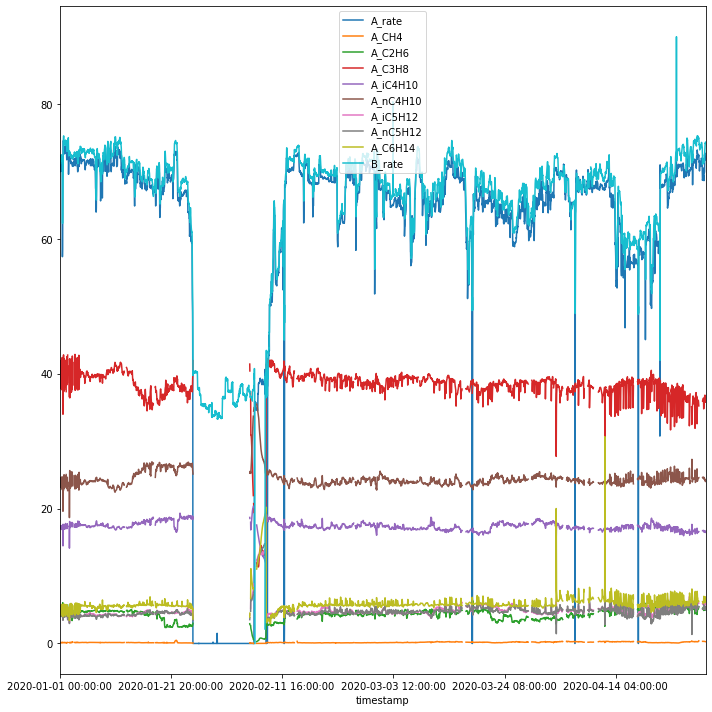

In [159]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[:].plot('timestamp')

# make room for tick labels
plt.tight_layout()


plt.show()

In [160]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480   
1     2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023   
2     2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965   
3     2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180   
4     2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587   
...                   ...        ...       ...       ...        ...   
3979  2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930   
3980  2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418   
3981  2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323   
3982  2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503   
3983  2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0     16.632260  24.062587  5.696004  4.939430  6.395286  74.273009  
1     16.651870  24.069800  5.676384  4.911872  6.346957  74.061833  
2     16.710967  24.106152  5.574873  4.808516  6.242636  73.856268  
3     16.683337  24.021993  5.514843  4.730887  6.101647  73.750744  
4     16.663863  24.003237  5.524898  4.728882  6.057119  73.698447  
...         ...        ...       ...       ...       ...        ...  
3979  17.741460  24.098520  4.469224  3.619095  4.686205  75.486026  
3980  17.449352  24.049532  4.770699  3.988215  6.689777  75.370451  
3981  17.635380  24.169473  4.613603  3.790651  5.785216  74.985878  
3982  17.758833  24.211013  4.504242  3.657459  5.094626  74.766867  
3983  17.772225  24.088445  4.387957  3.536302  4.863965  74.804667  

[3984 rows x 11 columns]

In [161]:
test_features.isnull().sum()

timestamp       0
A_rate       1142
A_CH4         456
A_C2H6        451
A_C3H8        452
A_iC4H10      452
A_nC4H10      452
A_iC5H12      456
A_nC5H12      456
A_C6H14       455
B_rate          5
dtype: int64

In [162]:
test_features.info()
test_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 11 columns):
timestamp    3984 non-null object
A_rate       2842 non-null float64
A_CH4        3528 non-null float64
A_C2H6       3533 non-null float64
A_C3H8       3532 non-null float64
A_iC4H10     3532 non-null float64
A_nC4H10     3532 non-null float64
A_iC5H12     3528 non-null float64
A_nC5H12     3528 non-null float64
A_C6H14      3529 non-null float64
B_rate       3979 non-null float64
dtypes: float64(10), object(1)
memory usage: 342.5+ KB


(3984, 11)

In [163]:
test_features.describe()

A_rate        A_CH4       A_C2H6       A_C3H8     A_iC4H10  \
count  2842.000000  3528.000000  3533.000000  3532.000000  3532.000000   
mean     69.884320     0.162207     4.467679    39.109041    17.397629   
std       2.975072     0.051789     0.475805     2.194943     1.178583   
min       0.001292     0.000000     0.000000     3.891164     0.000000   
25%      69.168728     0.126446     4.236493    38.392097    16.856905   
50%      70.152686     0.147803     4.464768    39.061776    17.276783   
75%      71.289177     0.173982     4.731939    40.305470    18.068539   
max      74.346769     0.390817     6.551086   100.000000    54.028570   

          A_nC4H10     A_iC5H12     A_nC5H12      A_C6H14       B_rate  
count  3532.000000  3528.000000  3528.000000  3529.000000  3979.000000  
mean     23.899568     4.871338     4.450333     5.613259    72.461288  
std       0.851144     0.629635     0.666401     2.049381     2.221912  
min       0.000000     0.000000     0.000000     0.000000    44.154610  
25%      23.579122     4.381023     3.842573     4.748398    71.653297  
50%      23.898327     4.775210     4.565247     5.943392    72.612522  
75%      24.259839     5.196619     4.922047     6.127190    73.800168  
max      34.284363    13.819660    11.846500    83.718820    94.243585

По максимальным значениям можно обнаружить наличие выбросов

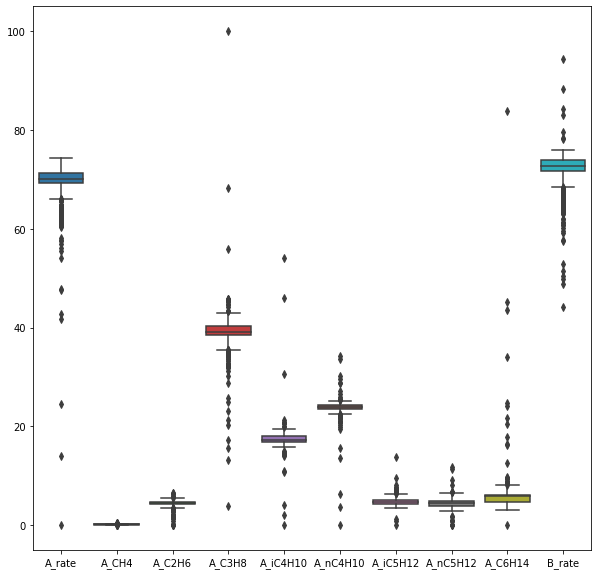

In [164]:
sns.boxplot(data=test_features)

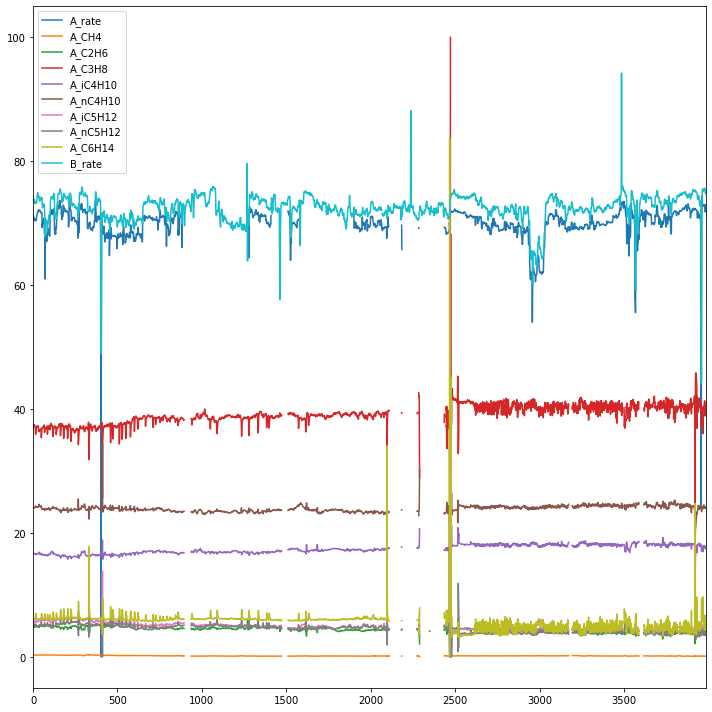

In [165]:
plt.rcParams["figure.figsize"] = (10,10)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [166]:
#dict_clean = {'A_C3H8':45, 'A_iC4H10':30, 'A_C6H14':15}

In [167]:
#for i in range(1,test_features.shape[0]):
#    for j in dict_clean:
#        if test_features.loc[i,j] > dict_clean[j]:
#            test_features.loc[[i],[j]] = test_features.loc[[i-1],[j]]

In [168]:
train_target[:]

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
0     2020-01-01 00:00:00  4.561979  39.015486  17.250740  24.301793
1     2020-01-01 00:30:00  4.550741  39.048915  17.229506  24.257461
2     2020-01-01 01:00:00  4.506793  38.766378  17.171621  24.236298
3     2020-01-01 01:30:00  4.584963  39.069360  17.218521  24.149843
4     2020-01-01 02:00:00  4.607483  38.817579  17.108668  24.049510
...                   ...       ...        ...        ...        ...
5803  2020-04-30 21:30:00  4.816865  35.539156  16.269938  24.770377
5804  2020-04-30 22:00:00  4.993286  36.067750  16.317757  24.729847
5805  2020-04-30 22:30:00  5.101574  36.275040  16.295460  24.629889
5806  2020-04-30 23:00:00  5.210675  36.872917  16.336359  24.438236
5807  2020-04-30 23:30:00  5.136487  35.860326  16.101509  24.426845

[5808 rows x 5 columns]

In [169]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [170]:
train_target.info()
train_target.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 5 columns):
timestamp    5808 non-null object
B_C2H6       5624 non-null float64
B_C3H8       5628 non-null float64
B_iC4H10     5628 non-null float64
B_nC4H10     5628 non-null float64
dtypes: float64(4), object(1)
memory usage: 227.0+ KB


(5808, 5)

In [171]:
train_target.describe()

B_C2H6       B_C3H8     B_iC4H10     B_nC4H10
count  5624.000000  5628.000000  5628.000000  5628.000000
mean      4.363701    37.742757    16.843028    24.171264
std       2.931240     2.218569     1.059827     1.480740
min       0.861025     0.026142     0.012764     0.019941
25%       3.503610    36.827096    16.548084    23.736470
50%       4.395271    37.750088    16.934576    24.147675
75%       4.680156    38.730979    17.292647    24.642044
max      91.573613    61.931856    19.235807    27.184879

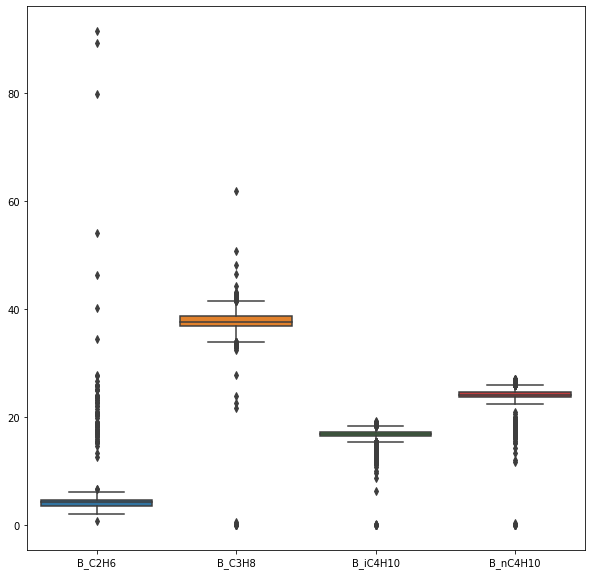

In [172]:
sns.boxplot(data=train_target)

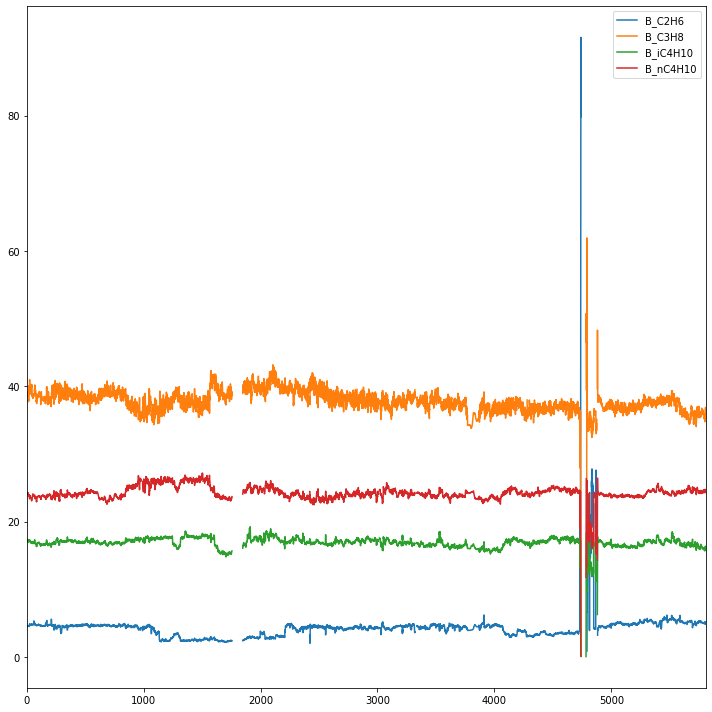

In [173]:
plt.rcParams["figure.figsize"] = (10,10)

train_target[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

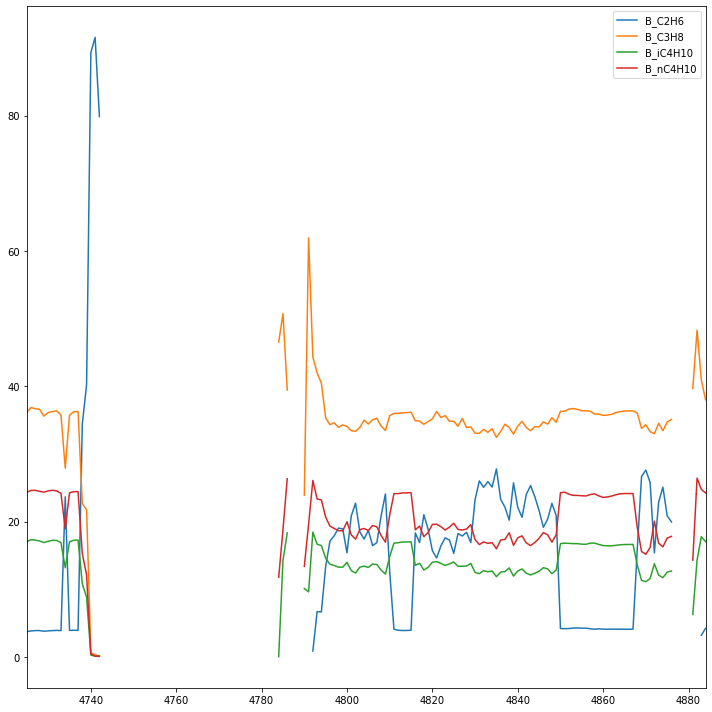

In [174]:
plt.rcParams["figure.figsize"] = (10,10)

train_target[4725:4885].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [175]:
drop_list = [i for i in range(4725,4885)]

In [176]:
train_features = train_features.drop(drop_list, axis=0)
train_features = train_features.reset_index(drop=True)

In [177]:
train_target = train_target.drop(drop_list, axis=0)
train_target = train_target.reset_index(drop=True)

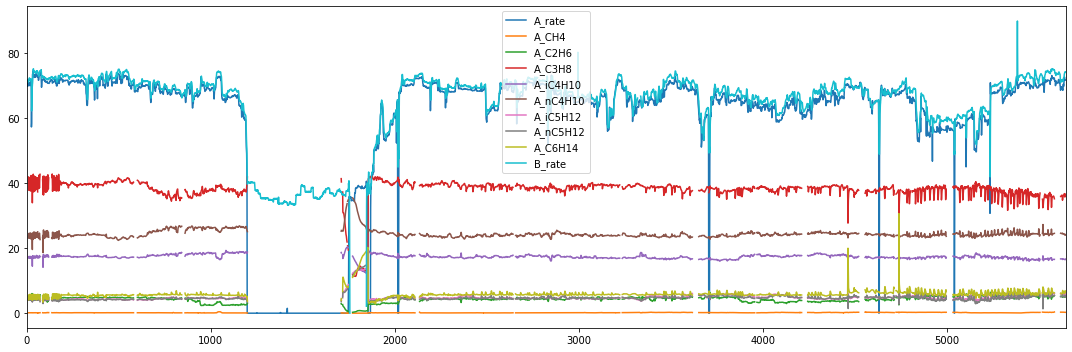

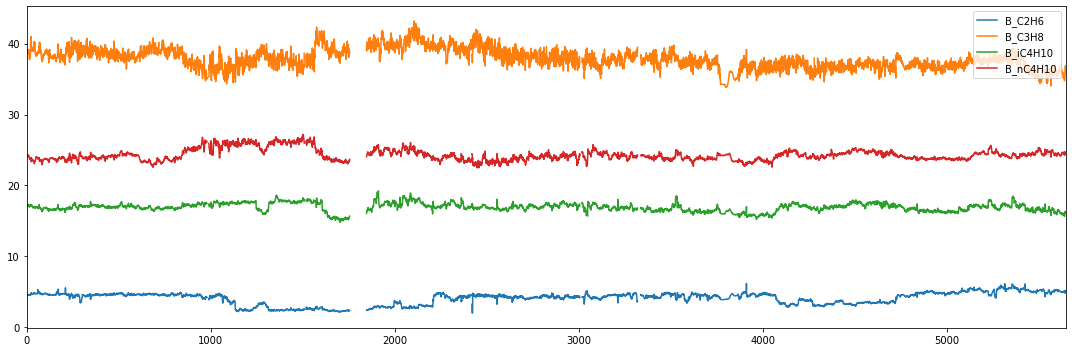

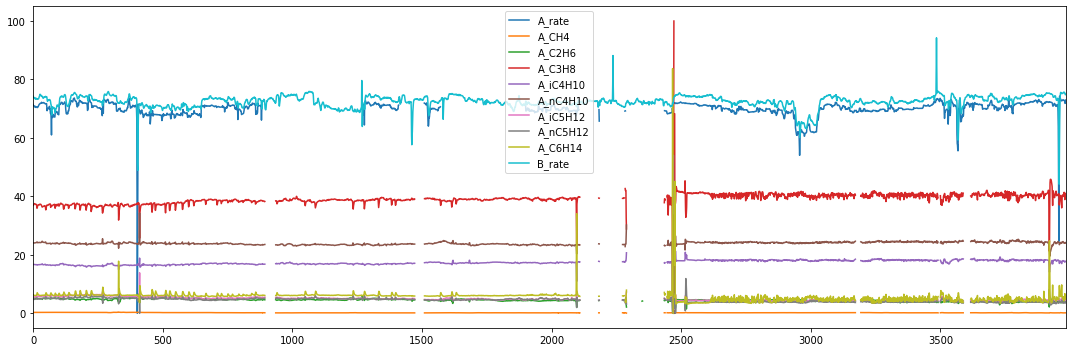

In [178]:
plt.rcParams["figure.figsize"] = (15,5)

train_features[:].plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)

train_target[:].plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [179]:
#dict_clean = {'B_C2H6':30, 'B_C3H8':50}

In [180]:
#for i in range(1,train_target.shape[0]):
#    for j in dict_clean:
#        if train_target.loc[i,j] > dict_clean[j]:
#            train_target.loc[[i],[j]] = train_target.loc[[i-1],[j]]

## Трансформация датасета

Попробуем оценить кажущийся отклик

In [181]:
#train_features[['A_rate','B_rate']]

In [182]:
#derivatives_A = pd.DataFrame()
#derivatives_B = pd.DataFrame()

#derivatives_A['der_A_rate']=[]
#derivatives_B['der_B_rate']=[]

#for i in range(train_features[['A_rate','B_rate']].shape[1]):
#    for j in range(train_features[['A_rate','B_rate']].shape[0]-1):
#        x = train_features[['A_rate','B_rate']].iloc[j,i]
#        y = train_features[['A_rate','B_rate']].iloc[j+1,i]
        
#        if i == 0:
#            new_line = {'der_A_rate':(y-x)/30}
#            derivatives_A = derivatives_A.append(new_line, ignore_index=True)
#        else:
#            new_line = {'der_B_rate':(y-x)/30}
#            derivatives_B = derivatives_B.append(new_line, ignore_index=True)

In [183]:
#derivatives = pd.concat([derivatives_A,derivatives_B.reset_index(drop=True)], axis=1)
#derivatives

In [184]:
# Сдвиг по времени 0
#(derivatives['der_A_rate'] - derivatives['der_B_rate']).apply(np.abs).mean()

In [185]:
# Сдвиг по времени 30 минут
#x = derivatives['der_A_rate'][0:-1]
#y = derivatives['der_B_rate'][1:]
#z = pd.concat([x,y.reset_index(drop=True)], axis=1)
#(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

In [186]:
#plt.rcParams["figure.figsize"] = (10,10)

#z[0:500].plot()

# make room for tick labels
#plt.tight_layout()

#plt.show()

In [187]:
# Сдвиг по времени 60 минут
#x = derivatives['der_A_rate'][0:-2]
#y = derivatives['der_B_rate'][2:]
#z = pd.concat([x,y.reset_index(drop=True)], axis=1)
#(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

In [188]:
# Сдвиг по времени 90 минут
#x = derivatives['der_A_rate'][0:-3]
#y = derivatives['der_B_rate'][3:]
#z = pd.concat([x,y.reset_index(drop=True)], axis=1)
#(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

Кажущийся отклик по расходу: 30 минут +- 15 минут

In [189]:
#der = pd.concat([train_features[['A_C3H8']],train_target[['B_C3H8']].reset_index(drop=True)], axis=1)
#der

In [190]:
#derivatives_A = pd.DataFrame()
#derivatives_B = pd.DataFrame()

#derivatives_A['der_A_C3H8']=[]
#derivatives_B ['der_B_C3H8']=[]

#for i in range(der[['A_C3H8','B_C3H8']].shape[1]):
#    for j in range(der[['A_C3H8','B_C3H8']].shape[0]-1):
#        x = der[['A_C3H8','B_C3H8']].iloc[j,i]
#        y = der[['A_C3H8','B_C3H8']].iloc[j+1,i]
        
#        if i == 0:
#            new_line = {'der_A_C3H8':(y-x)/30}
#            derivatives_A = derivatives_A.append(new_line, ignore_index=True)
#        else:
#            new_line = {'der_B_C3H8':(y-x)/30}
#            derivatives_B = derivatives_B.append(new_line, ignore_index=True)

In [191]:
#derivatives = pd.concat([derivatives_A,derivatives_B.reset_index(drop=True)], axis=1)
#derivatives

In [192]:
#sum_list = []
#for i in range(1, 1000):
#    x = derivatives['der_A_C3H8'][0:-i]
#    y = derivatives['der_B_C3H8'][i:]
#    z = pd.concat([x,y.reset_index(drop=True)], axis=1)
#    a = (z['der_A_C3H8'] - z['der_B_C3H8']).apply(np.abs).mean()
#    sum_list.append(a)

In [193]:
#min(sum_list)

In [194]:
#sum_pd = pd.DataFrame()
#sum_pd['sum'] = sum_list
#plt.rcParams["figure.figsize"] = (10,10)

#sum_pd[:].plot()

# make room for tick labels
#plt.tight_layout()

#plt.show()

In [195]:
#x = derivatives['der_A_C3H8'][0:-1]
#y = derivatives['der_B_C3H8'][1:]
#z = pd.concat([x,y.reset_index(drop=True)], axis=1)
#(z['der_A_C3H8'] - z['der_B_C3H8']).apply(np.abs).mean()

In [196]:
T=1

In [197]:
data = pd.concat([train_features,train_target.drop(['timestamp'], axis=1)], axis=1)
data.isnull().sum()

timestamp      0
A_rate         1
A_CH4        890
A_C2H6       890
A_C3H8       890
A_iC4H10     890
A_nC4H10     890
A_iC5H12     890
A_nC5H12     890
A_C6H14      890
B_rate       132
B_C2H6       139
B_C3H8       139
B_iC4H10     139
B_nC4H10     139
dtype: int64

In [198]:
data = data.ffill(axis = 0)
data.isnull().sum()

timestamp    0
A_rate       0
A_CH4        9
A_C2H6       9
A_C3H8       9
A_iC4H10     9
A_nC4H10     9
A_iC5H12     9
A_nC5H12     9
A_C6H14      9
B_rate       0
B_C2H6       0
B_C3H8       0
B_iC4H10     0
B_nC4H10     0
dtype: int64

In [199]:
NaNList = []
x = (data.isnull().sum(axis=1) > 0)
for i in range(x.shape[0]):
    if x[i] == True:
        NaNList.append(i)
data.drop(NaNList, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [200]:
data

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 04:30:00  71.055792  0.126244  5.242957  41.941480   
1     2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330   
2     2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656   
3     2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493   
4     2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510   
...                   ...        ...       ...       ...        ...   
5634  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5635  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5636  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5637  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5638  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6  \
0     17.064213  23.205953  4.184848  4.062079  4.110170  71.389674  4.532649   
1     17.440245  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543   
2     17.353362  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879   
3     17.098163  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837   
4     16.964787  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611   
...         ...        ...       ...       ...       ...        ...       ...   
5634  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  4.816865   
5635  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  4.993286   
5636  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  5.101574   
5637  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  5.210675   
5638  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  5.136487   

         B_C3H8   B_iC4H10   B_nC4H10  
0     38.604149  17.238489  24.275393  
1     38.510623  17.193441  24.242152  
2     39.124029  17.301609  24.211492  
3     38.247333  17.118282  24.044074  
4     37.985776  17.038811  23.931490  
...         ...        ...        ...  
5634  35.539156  16.269938  24.770377  
5635  36.067750  16.317757  24.729847  
5636  36.275040  16.295460  24.629889  
5637  36.872917  16.336359  24.438236  
5638  35.860326  16.101509  24.426845  

[5639 rows x 15 columns]

In [201]:
data_prev = data
data = data.rolling(25, min_periods=0).mean()

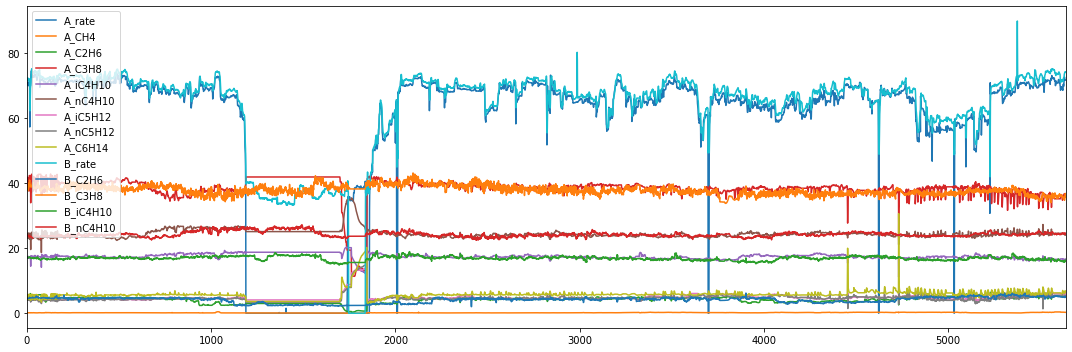

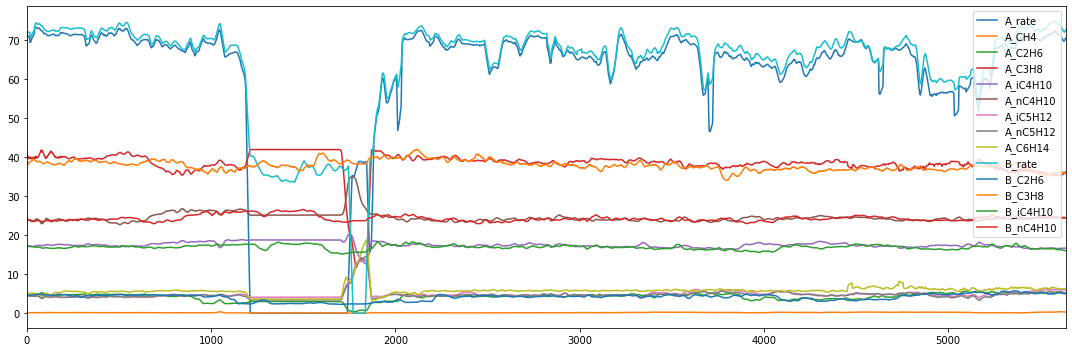

In [202]:
plt.rcParams["figure.figsize"] = (15,5)
data_prev[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[:].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

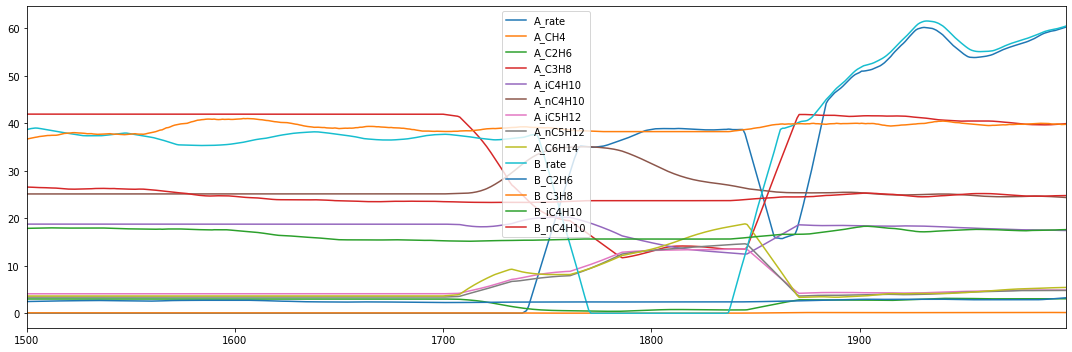

In [203]:
plt.rcParams["figure.figsize"] = (15,5)

plt.rcParams["figure.figsize"] = (15,5)
data[1500:2000].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [204]:
data[data[:] < 0].isnull().sum()

A_rate      5639
A_CH4       5639
A_C2H6      5639
A_C3H8      5639
A_iC4H10    5639
A_nC4H10    5639
A_iC5H12    5639
A_nC5H12    5639
A_C6H14     5639
B_rate      5639
B_C2H6      5639
B_C3H8      5639
B_iC4H10    5639
B_nC4H10    5639
dtype: int64

In [205]:
data['timestamp'] = data_prev['timestamp']
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.055792  0.126244  5.242957  41.941480  17.064213  23.205953   
1     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
2     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
3     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
4     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
...         ...       ...       ...        ...        ...        ...   
5634  70.011434  0.311899  5.102604  36.059145  16.656132  24.461361   
5635  70.138927  0.307879  5.083436  36.085269  16.650851  24.440942   
5636  70.258695  0.306373  5.077539  36.098835  16.642139  24.416459   
5637  70.376650  0.304539  5.073333  36.125671  16.635892  24.392833   
5638  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.184848  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489   
1     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
2     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
3     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
4     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
...        ...       ...       ...        ...       ...        ...        ...   
5634  5.904529  5.201483  6.246366  72.121189  5.010871  35.756568  15.997002   
5635  5.904031  5.198986  6.272643  72.237662  5.010089  35.757599  16.005038   
5636  5.901267  5.200797  6.300740  72.362225  5.013248  35.766447  16.013172   
5637  5.894854  5.196923  6.320211  72.481486  5.020496  35.803156  16.026852   
5638  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10            timestamp  
0     24.275393  2020-01-01 04:30:00  
1     24.258773  2020-01-01 05:00:00  
2     24.243013  2020-01-01 05:30:00  
3     24.193278  2020-01-01 06:00:00  
4     24.140920  2020-01-01 06:30:00  
...         ...                  ...  
5634  24.464644  2020-04-30 21:30:00  
5635  24.481749  2020-04-30 22:00:00  
5636  24.497347  2020-04-30 22:30:00  
5637  24.507734  2020-04-30 23:00:00  
5638  24.517125  2020-04-30 23:30:00  

[5639 rows x 15 columns]

In [206]:
monthList =[]
for i in data['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [207]:
data['month'] = monthList

In [208]:
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.055792  0.126244  5.242957  41.941480  17.064213  23.205953   
1     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
2     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
3     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
4     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
...         ...       ...       ...        ...        ...        ...   
5634  70.011434  0.311899  5.102604  36.059145  16.656132  24.461361   
5635  70.138927  0.307879  5.083436  36.085269  16.650851  24.440942   
5636  70.258695  0.306373  5.077539  36.098835  16.642139  24.416459   
5637  70.376650  0.304539  5.073333  36.125671  16.635892  24.392833   
5638  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.184848  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489   
1     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
2     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
3     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
4     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
...        ...       ...       ...        ...       ...        ...        ...   
5634  5.904529  5.201483  6.246366  72.121189  5.010871  35.756568  15.997002   
5635  5.904031  5.198986  6.272643  72.237662  5.010089  35.757599  16.005038   
5636  5.901267  5.200797  6.300740  72.362225  5.013248  35.766447  16.013172   
5637  5.894854  5.196923  6.320211  72.481486  5.020496  35.803156  16.026852   
5638  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10            timestamp  month  
0     24.275393  2020-01-01 04:30:00      1  
1     24.258773  2020-01-01 05:00:00      1  
2     24.243013  2020-01-01 05:30:00      1  
3     24.193278  2020-01-01 06:00:00      1  
4     24.140920  2020-01-01 06:30:00      1  
...         ...                  ...    ...  
5634  24.464644  2020-04-30 21:30:00      4  
5635  24.481749  2020-04-30 22:00:00      4  
5636  24.497347  2020-04-30 22:30:00      4  
5637  24.507734  2020-04-30 23:00:00      4  
5638  24.517125  2020-04-30 23:30:00      4  

[5639 rows x 16 columns]

In [209]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month'],
      dtype='object')

In [210]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

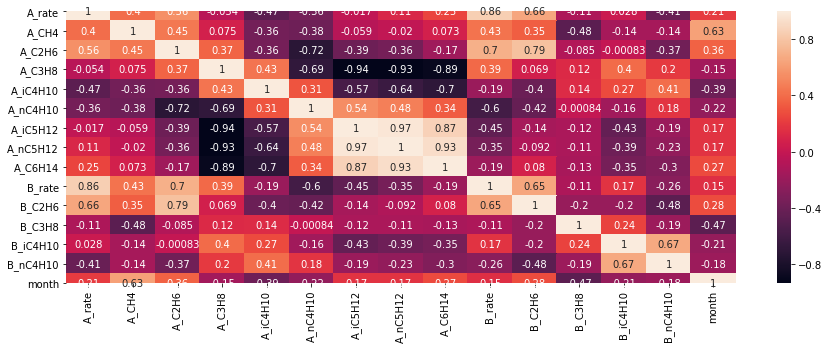

In [211]:
sns.heatmap(data.corr(), annot=True)

По [1] выпишем плотности сжиженных газов при 0 град Цельсия:

In [212]:
# кг/м3
ro_CH4 = 300.0 #Не нашел, указал из логических соображений
ro_C2H6 = 404.8
ro_C3H8 = 529.7
ro_iC4H10 = 581.0
ro_nC4H10 = 601.0
ro_iC5H12 = 639.2
ro_nC5H12 = 645.5
ro_C6H14 = 677.2

по [2] стр 65 выпишем динамическую вязкость сжиженных газов при 0 град Цельсия:

In [213]:
# Па*с
mu_CH4 = 10e-6 #Не нашел, указал из логических соображений
mu_C2H6 = 65e-6
mu_C3H8 = 140e-6
mu_iC4H10 = 225e-6
mu_nC4H10 = 215e-6
mu_iC5H12 = 285e-6
mu_nC5H12 = 295e-6
mu_C6H14 = 360e-6 #Не нашел, указал из логических соображений

по [3] выпишем молярные массы:

In [214]:
# кг/кмоль
M_CH4 = 16.04
M_C2H6 = 30.07
M_C3H8 = 44.1
M_iC4H10 = 58.12
M_nC4H10 = 58.12
M_iC5H12 = 72.15
M_nC5H12 = 72.15
M_C6H14 = 86.18

In [215]:
data['G_A_CH4'] = data['A_rate'] * data['A_CH4'] / 100
data['G_A_C2H6'] = data['A_rate'] * data['A_C2H6'] / 100
data['G_A_C3H8'] = data['A_rate'] * data['A_C3H8'] / 100
data['G_A_iC4H10'] = data['A_rate'] * data['A_iC4H10'] / 100
data['G_A_nC4H10'] = data['A_rate'] * data['A_nC4H10'] / 100
data['G_A_iC5H12'] = data['A_rate'] * data['A_iC5H12'] / 100
data['G_A_nC5H12'] = data['A_rate'] * data['A_nC5H12'] / 100
data['G_A_C6H14'] = data['A_rate'] * data['A_C6H14'] / 100

data['G_B_C2H6'] = data['B_rate'] * data['B_C2H6'] / 100
data['G_B_C3H8'] = data['B_rate'] * data['B_C3H8'] / 100
data['G_B_iC4H10'] = data['B_rate'] * data['B_iC4H10'] / 100
data['G_B_nC4H10'] = data['B_rate'] * data['B_nC4H10'] / 100

In [216]:
data['ro_mix_A'] = ((data['A_CH4'] / 100 / ro_CH4) + (data['A_C2H6'] / 100 / ro_C2H6) 
                  + (data['A_C3H8'] / 100 / ro_C3H8) + (data['A_iC4H10'] / 100 / ro_iC4H10) 
                  + (data['A_nC4H10'] / 100 / ro_nC4H10) + (data['A_iC5H12'] / 100 / ro_iC5H12)
                  + (data['A_nC5H12'] / 100 / ro_nC5H12) + (data['A_C6H14'] / 100 / ro_C6H14))**-1

In [217]:
data['mu_mix_A'] = (((data['A_CH4'] / 100) * (data['ro_mix_A'] / ro_CH4)) / mu_CH4 
                  + ((data['A_C2H6'] / 100) * (data['ro_mix_A'] / ro_C2H6)) / mu_C2H6 
                  + ((data['A_C3H8'] / 100) * (data['ro_mix_A'] / ro_C3H8)) / mu_C3H8
                  + ((data['A_iC4H10'] / 100) * (data['ro_mix_A'] / ro_iC4H10)) / mu_iC4H10
                  + ((data['A_nC4H10'] / 100) * (data['ro_mix_A'] / ro_nC4H10)) / mu_nC4H10
                  + ((data['A_iC5H12'] / 100) * (data['ro_mix_A'] / ro_iC5H12)) / mu_iC5H12
                  + ((data['A_nC5H12'] / 100) * (data['ro_mix_A'] / ro_nC5H12)) / mu_nC5H12
                  + ((data['A_C6H14'] / 100) * (data['ro_mix_A'] / ro_C6H14)) / mu_C6H14)**-1

In [218]:
data['w_A'] = (4*data['A_rate']*0.278)/(3.14*data['ro_mix_A']*0.16)
data['Re_A'] = (4*data['A_rate']*0.278)/(3.14*0.4*data['mu_mix_A'])

In [219]:
data['A_rate**2'] = data['A_rate']**2
data['sqrt_A_rate'] = data['A_rate'].apply(m.sqrt)
data['e**A_rate'] = data['A_rate'].apply(m.exp)
data['lg_A_rate'] = data['A_rate'].apply(m.log10)
data['ln_A_rate'] = data['A_rate'].apply(m.log)

data['B_rate**2'] = data['B_rate']**2
data['sqrt_B_rate'] = data['B_rate'].apply(m.sqrt)
data['e**B_rate'] = data['B_rate'].apply(m.exp)
#data['lg_B_rate'] = data['B_rate'].apply(m.log10)
#data['ln_B_rate'] = data['B_rate'].apply(m.log)

data['Re_A**2'] = data['Re_A']**2
data['sqrt_Re_A'] = data['Re_A'].apply(m.sqrt)
#data['e**Re_A'] = data['Re_A'].apply(m.exp)
data['lg_Re_A'] = data['Re_A'].apply(m.log10)
data['ln_Re_A'] = data['Re_A'].apply(m.log)

In [220]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.055792  0.126244  5.242957  41.941480  17.064213  23.205953  4.184848   
1  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   
2  71.031519  0.120907  4.868781  39.671489  17.285940  24.035055  4.549487   
3  71.038667  0.126067  4.955144  39.694490  17.238996  23.965851  4.540177   
4  71.044506  0.129636  5.052282  40.078894  17.184154  23.797004  4.474668   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489  24.275393   
1  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965  24.258773   
2  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513  24.243013   
3  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955  24.193278   
4  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127  24.140920   

             timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  2020-01-01 04:30:00      1  0.089704  3.725424  29.801851   12.125112   
1  2020-01-01 05:00:00      1  0.084380  3.507886  28.822011   12.256473   
2  2020-01-01 05:30:00      1  0.085882  3.458369  28.179261   12.278466   
3  2020-01-01 06:00:00      1  0.089556  3.520068  28.198436   12.246353   
4  2020-01-01 06:30:00      1  0.092099  3.589369  28.473852   12.208397   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.489174    2.973577    2.886343   2.920514  3.235844  27.559376   
1   16.885985    3.126080    3.057606   3.261749  3.261401  27.603653   
2   17.072465    3.231570    3.179062   3.506462  3.287555  27.783881   
3   17.025021    3.225281    3.171124   3.521861  3.286083  27.734744   
4   16.906464    3.179006    3.117977   3.435498  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.306501   17.330124  557.275650  0.000152  0.282218  413051.697732   
1   12.325097   17.367120  559.415129  0.000155  0.281087  406691.601290   
2   12.365565   17.383997  560.509094  0.000156  0.280494  404402.122607   
3   12.360900   17.373582  560.268157  0.000155  0.280643  405816.722617   
4   12.351922   17.358515  559.631119  0.000154  0.280985  407882.237062   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5048.925626     8.429460  7.230004e+30   1.851599   4.263465  5096.485564   
1  5047.084656     8.428691  7.136939e+30   1.851520   4.263283  5125.284167   
2  5045.476739     8.428020  7.056623e+30   1.851451   4.263124  5141.929142   
3  5046.492171     8.428444  7.107240e+30   1.851495   4.263224  5156.906896   
4  5047.321876     8.428790  7.148864e+30   1.851531   4.263307  5170.320863   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  
0     8.449241  1.009582e+31  1.706117e+11  642.690982  5.616004  12.931328  
1     8.461152  1.234853e+31  1.653981e+11  637.723766  5.609265  12.915810  
2     8.468013  1.386952e+31  1.635411e+11  635.926193  5.606813  12.910165  
3     8.474173  1.539518e+31  1.646872e+11  637.037458  5.608330  12.913657  
4     8.479678  1.690130e+31  1.663679e+11  638.656588  5.610535  12.918734

In [221]:
data.loc[[0,]]

A_rate     A_CH4    A_C2H6    A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.055792  0.126244  5.242957  41.94148  17.064213  23.205953  4.184848   

   A_nC5H12  A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.062079  4.11017  71.389674  4.532649  38.604149  17.238489  24.275393   

             timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  2020-01-01 04:30:00      1  0.089704  3.725424  29.801851   12.125112   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.489174    2.973577    2.886343   2.920514  3.235844  27.559376   

   G_B_iC4H10  G_B_nC4H10   ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.306501   17.330124  557.27565  0.000152  0.282218  413051.697732   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5048.925626      8.42946  7.230004e+30   1.851599   4.263465  5096.485564   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  
0     8.449241  1.009582e+31  1.706117e+11  642.690982  5.616004  12.931328

In [222]:
data.loc[[T,]]

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
1  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   

   A_nC5H12   A_C6H14    B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
1  4.303891  4.591243  71.59109  4.555596  38.557386  17.215965  24.258773   

             timestamp  month  G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
1  2020-01-01 05:00:00      1  0.08438  3.507886  28.822011   12.256473   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
1   16.885985     3.12608    3.057606   3.261749  3.261401  27.603653   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A          Re_A  \
1   12.325097    17.36712  559.415129  0.000155  0.281087  406691.60129   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
1  5047.084656     8.428691  7.136939e+30    1.85152   4.263283  5125.284167   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A   ln_Re_A  
1     8.461152  1.234853e+31  1.653981e+11  637.723766  5.609265  12.91581

In [223]:
Ct_A = pd.DataFrame({'Ct_A_C2H6':[np.nan]*T,'Ct_A_C3H8':[np.nan]*T,'Ct_A_iC4H10':[np.nan]*T,
                     'Ct_A_nC4H10':[np.nan]*T})

Cx_A = pd.DataFrame({'Cx_A_C2H6':[np.nan]*T,'Cx_A_C3H8':[np.nan]*T,'Cx_A_iC4H10':[np.nan]*T,
                     'Cx_A_nC4H10':[np.nan]*T})

G = data[['G_A_C2H6', 'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10',
          'G_B_C2H6', 'G_B_C3H8','G_B_iC4H10', 'G_B_nC4H10']]

In [224]:
for i in range(G.shape[0]-T):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i+T,j]
        new_line.update({Ct_A .columns[j]:(y-x)})
    Ct_A = Ct_A.append(new_line, ignore_index=True)

In [225]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.507886  28.822011   12.256473   16.885985  3.261401  27.603653   
2  3.458369  28.179261   12.278466   17.072465  3.287555  27.783881   
3  3.520068  28.198436   12.246353   17.025021  3.286083  27.734744   
4  3.589369  28.473852   12.208397   16.906464  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.325097   17.367120  
2   12.365565   17.383997  
3   12.360900   17.373582  
4   12.351922   17.358515

In [226]:
Ct_A 

Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10
0           NaN        NaN          NaN          NaN
1     -0.217538  -0.979840     0.131361     0.396811
2     -0.049517  -0.642750     0.021993     0.186480
3      0.061699   0.019175    -0.032113    -0.047444
4      0.069300   0.275416    -0.037955    -0.118557
...         ...        ...          ...          ...
5634  -0.009849   0.044844     0.010821     0.012842
5635  -0.006938   0.064296     0.017532     0.016865
5636   0.001945   0.052750     0.013821     0.012071
5637   0.003029   0.061467     0.015234     0.012173
5638  -0.000561   0.055675     0.016380     0.016305

[5639 rows x 4 columns]

In [227]:
for i in range(G.shape[0]-T):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i,j+4]
        new_line.update({Cx_A .columns[j]:(y-x)})
    Cx_A = Cx_A.append(new_line, ignore_index=True)

In [228]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.507886  28.822011   12.256473   16.885985  3.261401  27.603653   
2  3.458369  28.179261   12.278466   17.072465  3.287555  27.783881   
3  3.520068  28.198436   12.246353   17.025021  3.286083  27.734744   
4  3.589369  28.473852   12.208397   16.906464  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.325097   17.367120  
2   12.365565   17.383997  
3   12.360900   17.373582  
4   12.351922   17.358515

In [229]:
Cx_A

Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10
0           NaN        NaN          NaN          NaN
1     -0.489581  -2.242475     0.181389     0.840950
2     -0.246485  -1.218358     0.068624     0.481135
3     -0.170814  -0.395380     0.087099     0.311532
4     -0.233986  -0.463693     0.114547     0.348560
...         ...        ...          ...          ...
5634   0.034875   0.584620    -0.127066     0.500455
5635   0.041494   0.542537    -0.123969     0.518442
5636   0.053704   0.520633    -0.117063     0.542428
5637   0.060286   0.518827    -0.105062     0.572140
5638   0.068488   0.526622    -0.091283     0.596711

[5639 rows x 4 columns]

In [230]:
w = pd.DataFrame({'w_prev':[np.nan]*T})
j = pd.DataFrame({'w_prev':data['w_A']})
w = pd.concat([w,j], axis=0)
w = w.reset_index(drop=True)
a = [Cx_A.shape[0] + i for i in range(0, T)]
for i in a:
    w.drop(i, axis=0, inplace=True)
w = w.reset_index(drop=True)
w

w_prev
0          NaN
1     0.282218
2     0.281087
3     0.280494
4     0.280643
...        ...
5634  0.274930
5635  0.275224
5636  0.275694
5637  0.276149
5638  0.276608

[5639 rows x 1 columns]

In [231]:
x = data
y = pd.concat([Cx_A,Ct_A,w], axis=1)
data = pd.concat([data,y], axis=1)

In [232]:
for i in range(0,T):
    data.drop(i, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [233]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   
1  71.031519  0.120907  4.868781  39.671489  17.285940  24.035055  4.549487   
2  71.038667  0.126067  4.955144  39.694490  17.238996  23.965851  4.540177   
3  71.044506  0.129636  5.052282  40.078894  17.184154  23.797004  4.474668   
4  71.033900  0.129398  5.059953  40.298217  17.185181  23.729739  4.436506   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965  24.258773   
1  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513  24.243013   
2  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955  24.193278   
3  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127  24.140920   
4  4.346012  4.756399  71.996468  4.566859  38.369108  17.140317  24.083498   

             timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  2020-01-01 05:00:00      1  0.084380  3.507886  28.822011   12.256473   
1  2020-01-01 05:30:00      1  0.085882  3.458369  28.179261   12.278466   
2  2020-01-01 06:00:00      1  0.089556  3.520068  28.198436   12.246353   
3  2020-01-01 06:30:00      1  0.092099  3.589369  28.473852   12.208397   
4  2020-01-01 07:00:00      1  0.091916  3.594282  28.625395   12.207304   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.885985    3.126080    3.057606   3.261749  3.261401  27.603653   
1   17.072465    3.231570    3.179062   3.506462  3.287555  27.783881   
2   17.025021    3.225281    3.171124   3.521861  3.286083  27.734744   
3   16.906464    3.179006    3.117977   3.435498  3.287569  27.679363   
4   16.856159    3.151423    3.087142   3.378656  3.287977  27.624403   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.325097   17.367120  559.415129  0.000155  0.281087  406691.601290   
1   12.365565   17.383997  560.509094  0.000156  0.280494  404402.122607   
2   12.360900   17.373582  560.268157  0.000155  0.280643  405816.722617   
3   12.351922   17.358515  559.631119  0.000154  0.280985  407882.237062   
4   12.340423   17.339268  559.383748  0.000154  0.281068  408308.687585   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5047.084656     8.428691  7.136939e+30   1.851520   4.263283  5125.284167   
1  5045.476739     8.428020  7.056623e+30   1.851451   4.263124  5141.929142   
2  5046.492171     8.428444  7.107240e+30   1.851495   4.263224  5156.906896   
3  5047.321876     8.428790  7.148864e+30   1.851531   4.263307  5170.320863   
4  5045.814882     8.428161  7.073439e+30   1.851466   4.263157  5183.491371   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  \
0     8.461152  1.234853e+31  1.653981e+11  637.723766  5.609265  12.915810   
1     8.468013  1.386952e+31  1.635411e+11  635.926193  5.606813  12.910165   
2     8.474173  1.539518e+31  1.646872e+11  637.037458  5.608330  12.913657   
3     8.479678  1.690130e+31  1.663679e+11  638.656588  5.610535  12.918734   
4     8.485073  1.852118e+31  1.667160e+11  638.990366  5.610989  12.919779   

   Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  \
0  -0.489581  -2.242475     0.181389     0.840950  -0.217538  -0.979840   
1  -0.246485  -1.218358     0.068624     0.481135  -0.049517  -0.642750   
2  -0.170814  -0.395380     0.087099     0.311532   0.061699   0.019175   
3  -0.233986  -0.463693     0.114547     0.348560   0.069300   0.275416   
4  -0.301800  -0.794489     0.143525     0.452051   0.004913   0.151542   

   Ct_A_iC4H10  Ct_A_nC4H10    w_prev  
0     0.131361     0.396811  0.282218  
1     0.021993     0.186480  0.281087  
2    -0.032113    -0.047444  0.280494  
3    -0.037955    -0.118557  0.280643  
4    -0.001093    -0.050305  0.280985

In [234]:
data['Cx_A_C2H6**2'] = data['Cx_A_C2H6']**2
data['Cx_A_C3H8**2'] = data['Cx_A_C3H8']**2
data['Cx_A_iC4H10**2'] = data['Cx_A_iC4H10']**2
data['Cx_A_nC4H10**2'] = data['Cx_A_nC4H10']**2

data['E_C2H6'] = (data['Ct_A_C2H6'] + data['w_prev'] * data['Cx_A_C2H6'])/ data['Cx_A_C2H6**2']
data['E_C3H8'] = (data['Ct_A_C3H8'] + data['w_prev'] * data['Cx_A_C3H8'])/ data['Cx_A_C3H8**2']
data['E_iC4H10'] = (data['Ct_A_iC4H10'] + data['w_prev'] * data['Cx_A_iC4H10'])/ data['Cx_A_iC4H10**2']
data['E_nC4H10'] = (data['Ct_A_nC4H10'] + data['w_prev'] * data['Cx_A_nC4H10'])/ data['Cx_A_nC4H10**2']

data['Pe_ef_C2H6'] = np.abs(data['w_prev'] / data['E_C2H6'])
data['Pe_ef_C3H8'] = np.abs(data['w_prev'] / data['E_C3H8'])
data['Pe_ef_iC4H10'] = np.abs(data['w_prev'] / data['E_iC4H10'])
data['Pe_ef_nC4H10'] = np.abs(data['w_prev'] / data['E_nC4H10'])

In [235]:
data['Pe_ef_C2H6**2'] = data['Pe_ef_C2H6']**2
data['sqrt_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.sqrt)
data['e**Pe_ef_C2H6'] = (-1 * data['Pe_ef_C2H6']).apply(m.exp)
#data['lg_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log10)
#data['ln_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log)

data['Pe_ef_C3H8**2'] = data['Pe_ef_C3H8']**2
data['sqrt_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.sqrt)
data['e**Pe_ef_C3H8'] = (-1 * data['Pe_ef_C3H8']).apply(m.exp)
#data['lg_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log10)
#data['ln_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log)

data['Pe_ef_iC4H10**2'] = data['Pe_ef_iC4H10']**2
data['sqrt_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.sqrt)
data['e**Pe_ef_iC4H10'] = (-1 * data['Pe_ef_iC4H10']).apply(m.exp)
#data['lg_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log10)
#data['ln_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log)

data['Pe_ef_nC4H10**2'] = data['Pe_ef_nC4H10']**2
data['sqrt_Pe_ef_nC4H10'] = data['Pe_ef_nC4H10'].apply(m.sqrt)
data['e**Pe_ef_nC4H10'] = (-1 * data['Pe_ef_nC4H10']).apply(m.exp)
#data['lg_Pe_ef_nC4H10e'] = data['Pe_ef_nC4H10'].apply(m.log10)
#data['ln_Pe_ef_nC4H10'] = data['Pe_ef_nC4H10'].apply(m.log)

In [236]:
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
1     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
2     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
3     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
4     71.033900  0.129398  5.059953  40.298217  17.185181  23.729739   
...         ...       ...       ...        ...        ...        ...   
5633  70.011434  0.311899  5.102604  36.059145  16.656132  24.461361   
5634  70.138927  0.307879  5.083436  36.085269  16.650851  24.440942   
5635  70.258695  0.306373  5.077539  36.098835  16.642139  24.416459   
5636  70.376650  0.304539  5.073333  36.125671  16.635892  24.392833   
5637  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
1     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
2     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
3     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
4     4.436506  4.346012  4.756399  71.996468  4.566859  38.369108  17.140317   
...        ...       ...       ...        ...       ...        ...        ...   
5633  5.904529  5.201483  6.246366  72.121189  5.010871  35.756568  15.997002   
5634  5.904031  5.198986  6.272643  72.237662  5.010089  35.757599  16.005038   
5635  5.901267  5.200797  6.300740  72.362225  5.013248  35.766447  16.013172   
5636  5.894854  5.196923  6.320211  72.481486  5.020496  35.803156  16.026852   
5637  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10            timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  \
0     24.258773  2020-01-01 05:00:00      1  0.084380  3.507886  28.822011   
1     24.243013  2020-01-01 05:30:00      1  0.085882  3.458369  28.179261   
2     24.193278  2020-01-01 06:00:00      1  0.089556  3.520068  28.198436   
3     24.140920  2020-01-01 06:30:00      1  0.092099  3.589369  28.473852   
4     24.083498  2020-01-01 07:00:00      1  0.091916  3.594282  28.625395   
...         ...                  ...    ...       ...       ...        ...   
5633  24.464644  2020-04-30 21:30:00      4  0.218365  3.572406  25.245525   
5634  24.481749  2020-04-30 22:00:00      4  0.215943  3.565468  25.309821   
5635  24.497347  2020-04-30 22:30:00      4  0.215254  3.567413  25.362570   
5636  24.507734  2020-04-30 23:00:00      4  0.214325  3.570442  25.424037   
5637  24.517125  2020-04-30 23:30:00      4  0.213048  3.569881  25.479712   

      G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6  \
0      12.256473   16.885985    3.126080    3.057606   3.261749  3.261401   
1      12.278466   17.072465    3.231570    3.179062   3.506462  3.287555   
2      12.246353   17.025021    3.225281    3.171124   3.521861  3.286083   
3      12.208397   16.906464    3.179006    3.117977   3.435498  3.287569   
4      12.207304   16.856159    3.151423    3.087142   3.378656  3.287977   
...          ...         ...         ...         ...        ...       ...   
5633   11.661197   17.125750    4.133846    3.641633   4.373171  3.613900   
5634   11.678729   17.142614    4.141024    3.646513   4.399564  3.619171   
5635   11.692550   17.154685    4.146153    3.654012   4.426818  3.627698   
5636   11.707783   17.166859    4.148601    3.657421   4.447953  3.638930   
5637   11.724163   17.183164    4.152003    3.661481   4.466263  3.648088   

       G_B_C3H8  G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A  \
0     27.603653   12.325097   17.367120  559.415129  0.000155  0.281087   
1     27.783881   12.365565   17.383997  560.509094  0.000156  0.280494   
2     27.734744   12.360900   17.373582  560.268157  0.000155  0.280643   
3     27.

In [237]:
last_line = data[-T:]

In [238]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month', 'G_A_CH4', 'G_A_C2H6',
       'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12',
       'G_A_C6H14', 'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10',
       'ro_mix_A', 'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate',
       'e**A_rate', 'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate',
       'e**B_rate', 'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6',
       'Cx_A_C3H8', 'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'sqrt_Pe_ef_C2H6', 'e**Pe_ef_C2H6', 'Pe_ef_C3H8**2',
       'sqrt_Pe_ef_C3H

In [239]:
x = data.drop(labels=['timestamp','B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10',
                      'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10'], axis=1)

y = data[['B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10', 
                'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10']]

In [240]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

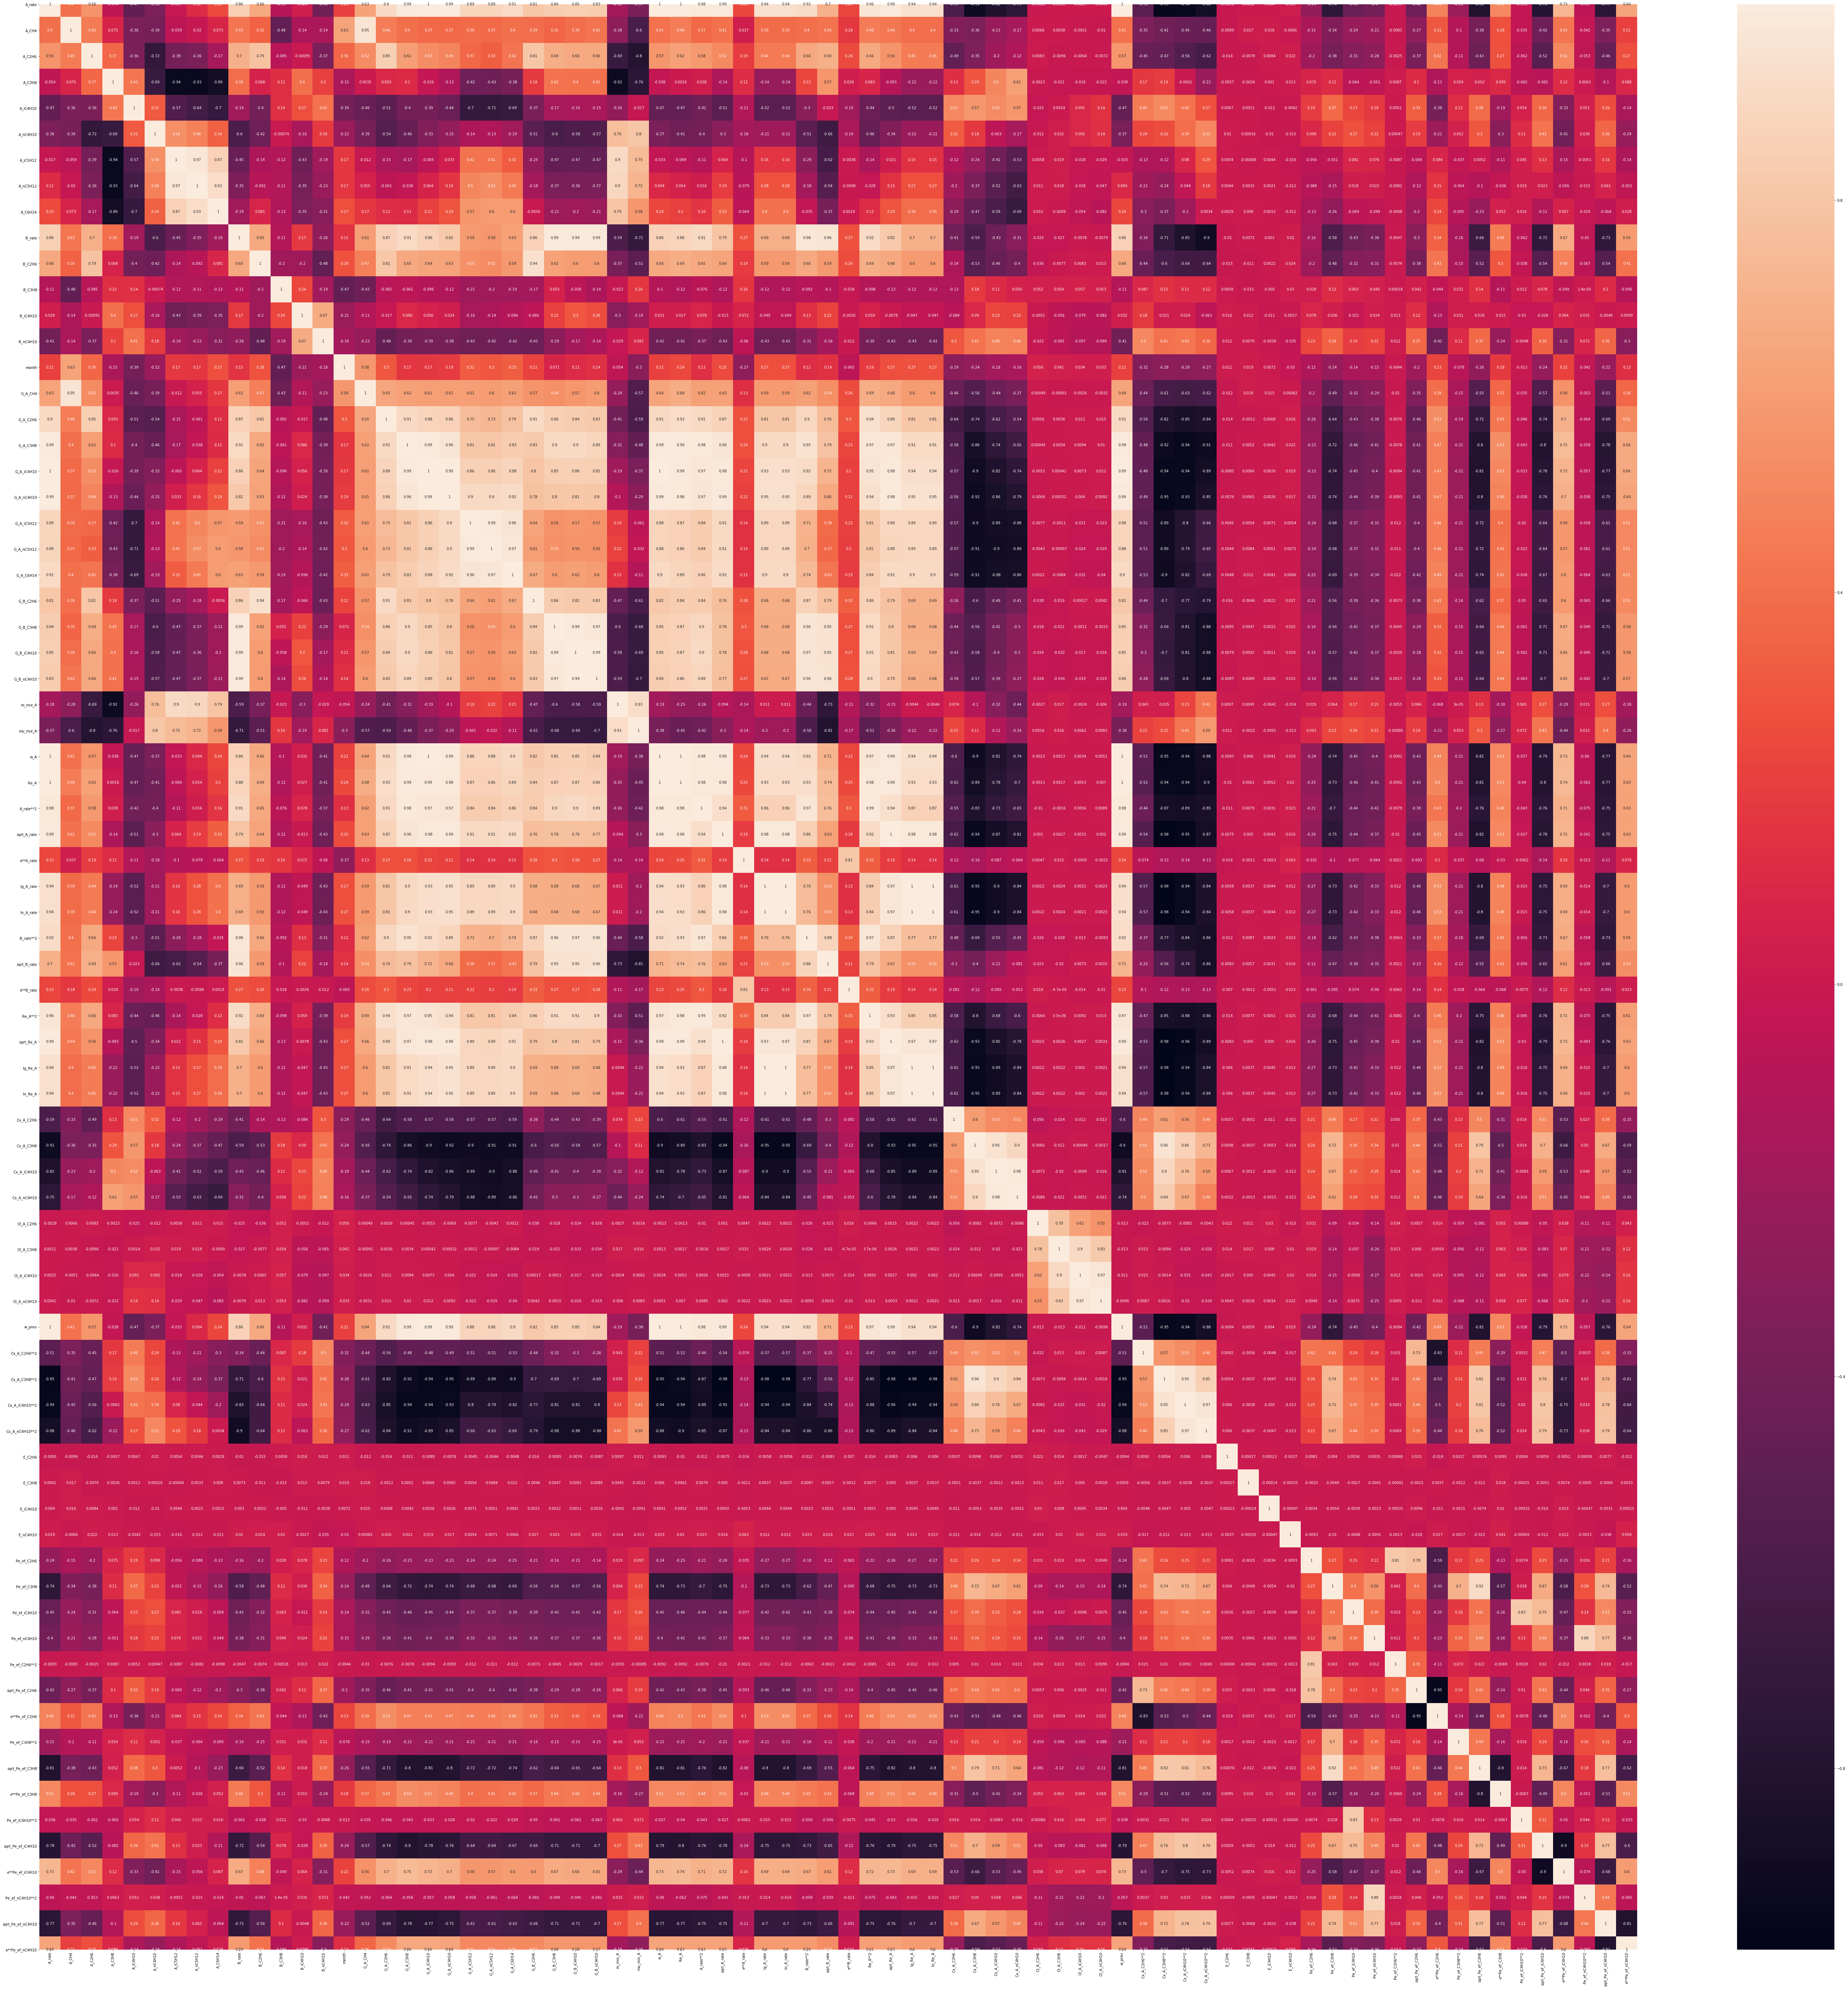

In [241]:
plt.figure(figsize=(100,100))
sns.heatmap(data.corr(), annot=True)

In [242]:
corrMatrix = pd.DataFrame()
corrMatrix['x'] = x.columns
corrMatrix['G_B_C2H6'] = np.array(x.corrwith(data['G_B_C2H6']))
corrMatrix['G_B_C3H8'] = np.array(x.corrwith(data['G_B_C3H8']))
corrMatrix['G_B_iC4H10'] = np.array(x.corrwith(data['G_B_iC4H10']))
corrMatrix['G_B_nC4H10'] = np.array(x.corrwith(data['G_B_nC4H10']))
corrMatrix['B_C2H6'] = np.array(x.corrwith(data['B_C2H6']))
corrMatrix['B_C3H8'] = np.array(x.corrwith(data['B_C3H8']))
corrMatrix['B_iC4H10'] = np.array(x.corrwith(data['B_iC4H10']))
corrMatrix['B_nC4H10'] = np.array(x.corrwith(data['B_nC4H10']))

In [243]:
corrMatrix

x  G_B_C2H6  G_B_C3H8  G_B_iC4H10  G_B_nC4H10    B_C2H6  \
0              A_rate  0.808801  0.841558    0.846426    0.834171  0.657299   
1               A_CH4  0.393961  0.349995    0.388835    0.423867  0.346058   
2              A_C2H6  0.805913  0.689469    0.664891    0.657132  0.786065   
3              A_C3H8  0.184589  0.415012    0.404587    0.406333  0.068487   
4            A_iC4H10 -0.366627 -0.166916   -0.160530   -0.149247 -0.403097   
5            A_nC4H10 -0.512975 -0.601301   -0.580228   -0.571475 -0.424340   
6            A_iC5H12 -0.254418 -0.473450   -0.470760   -0.469391 -0.138923   
7            A_nC5H12 -0.180587 -0.370443   -0.362341   -0.367812 -0.092076   
8             A_C6H14 -0.005569 -0.210680   -0.200665   -0.212078  0.080605   
9              B_rate  0.861999  0.986679    0.990286    0.990994  0.652790   
10              month  0.219150  0.071088    0.114834    0.136787  0.281208   
11            G_A_CH4  0.565525  0.536975    0.572220    0.598890  0.469057   
12           G_A_C2H6  0.911666  0.856869    0.841372    0.827510  0.808917   
13           G_A_C3H8  0.825757  0.904781    0.903690    0.889742  0.654603   
14         G_A_iC4H10  0.795433  0.851318    0.857441    0.845434  0.635913   
15         G_A_nC4H10  0.776451  0.801233    0.811777    0.801338  0.629830   
16         G_A_iC5H12  0.636646  0.557788    0.569411    0.565127  0.549940   
17         G_A_nC5H12  0.612309  0.547334    0.563364    0.555298  0.519675   
18          G_A_C6H14  0.671343  0.597878    0.615268    0.602485  0.585413   
19           ro_mix_A -0.470267 -0.597049   -0.584081   -0.587683 -0.373378   
20           mu_mix_A -0.611079 -0.684866   -0.686442   -0.700103 -0.509537   
21                w_A  0.815272  0.849749    0.853847    0.841518  0.662822   
22               Re_A  0.837225  0.867334    0.871015    0.860677  0.685115   
23          A_rate**2  0.836902  0.896373    0.899330    0.887103  0.652250   
24        sqrt_A_rate  0.763133  0.775635    0.780742    0.768264  0.637651   
25          e**A_rate  0.280500  0.300579    0.279463    0.271311  0.189854   
26          lg_A_rate  0.684781  0.676012    0.681347    0.668566  0.588595   
27          ln_A_rate  0.684781  0.676012    0.681347    0.668566  0.588595   
28          B_rate**2  0.870744  0.964568    0.967513    0.963252  0.660883   
29        sqrt_B_rate  0.789899  0.948656    0.951416    0.958327  0.587027   
30          e**B_rate  0.331647  0.268260    0.266441    0.280237  0.257264   
31            Re_A**2  0.863938  0.908180    0.908957    0.899302  0.685381   
32          sqrt_Re_A  0.786853  0.800713    0.805288    0.794035  0.658727   
33            lg_Re_A  0.692494  0.684688    0.690024    0.677518  0.595121   
34            ln_Re_A  0.692494  0.684688    0.690024    0.677518  0.595121   
35          Cx_A_C2H6 -0.264601 -0.440810   -0.429698   -0.393769 -0.136622   
36          Cx_A_C3H8 -0.604903 -0.564945   -0.580396   -0.568638 -0.528760   
37        Cx_A_iC4H10 -0.491064 -0.409529   -0.404425   -0.390283 -0.457490   
38        Cx_A_nC4H10 -0.410030 -0.300703   -0.296660   -0.273362 -0.399345   
39          Ct_A_C2H6 -0.037792 -0.018496   -0.023867   -0.027666 -0.036033   
40          Ct_A_C3H8 -0.018770 -0.020964   -0.032275   -0.034496 -0.007660   
41        Ct_A_iC4H10  0.000172 -0.001113   -0.016755   -0.019421  0.008327   
42        Ct_A_nC4H10  0.004154 -0.001509   -0.016378   -0.019424  0.012587   
43             w_prev  0.815442  0.850026    0.854313    0.842036  0.662824   
44       Cx_A_C2H6**2 -0.441920 -0.322340   -0.303109   -0.276851 -0.442604   
45       Cx_A_C3H8**2 -0.698492 -0.688292   -0.697964   -0.685675 -0.604138   
46     Cx_A_iC4H10**2 -0.767481 -0.811543   -0.809908   -0.803848 -0.641581   
47     Cx_A_nC4H10**2 -0.790715 -0.879473   -0.879002   -0.877925 -0.641682   
48             E_C2H6 -0.015592 -0.009503   -0.007382   -0.008674 -0.015129   
49             E_C3H8 -0.004601  0.004718    0.009220    0.008901 -0.0

In [244]:
for i in corrMatrix.drop(labels='x', axis=1).columns:
    print(i + ' = ' , sum(corrMatrix[i].apply(abs)))

G_B_C2H6 =  32.84271699247965
G_B_C3H8 =  33.91803755962562
G_B_iC4H10 =  34.008993620550584
G_B_nC4H10 =  33.64462645499367
B_C2H6 =  27.514131298104257
B_C3H8 =  7.233287660906653
B_iC4H10 =  6.438235514298126
B_nC4H10 =  18.912534837843385


In [245]:
corrMatrix[(corrMatrix['G_B_C2H6'] > 0.6) | (corrMatrix['G_B_C2H6'] < -0.6)][['x', 'G_B_C2H6']]

x  G_B_C2H6
0              A_rate  0.808801
2              A_C2H6  0.805913
9              B_rate  0.861999
12           G_A_C2H6  0.911666
13           G_A_C3H8  0.825757
14         G_A_iC4H10  0.795433
15         G_A_nC4H10  0.776451
16         G_A_iC5H12  0.636646
17         G_A_nC5H12  0.612309
18          G_A_C6H14  0.671343
20           mu_mix_A -0.611079
21                w_A  0.815272
22               Re_A  0.837225
23          A_rate**2  0.836902
24        sqrt_A_rate  0.763133
26          lg_A_rate  0.684781
27          ln_A_rate  0.684781
28          B_rate**2  0.870744
29        sqrt_B_rate  0.789899
31            Re_A**2  0.863938
32          sqrt_Re_A  0.786853
33            lg_Re_A  0.692494
34            ln_Re_A  0.692494
36          Cx_A_C3H8 -0.604903
43             w_prev  0.815442
45       Cx_A_C3H8**2 -0.698492
46     Cx_A_iC4H10**2 -0.767481
47     Cx_A_nC4H10**2 -0.790715
60    sqrt_Pe_ef_C3H8 -0.616922
63  sqrt_Pe_ef_iC4H10 -0.653803
66  sqrt_Pe_ef_nC4H10 -0.661935

In [246]:
d = data[['B_rate', 'Re_A',
          'G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10',
          #'Cx_A_C2H6',
          'Cx_A_C3H8', #'Cx_A_iC4H10', 'Cx_A_nC4H10',
          #'Cx_A_C2H6**2',
          'Cx_A_C3H8**2', 'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2',
          #'Pe_ef_C2H6','Pe_ef_C3H8','Pe_ef_iC4H10','Pe_ef_nC4H10',
          #'sqrt_Pe_ef_C2H6',
          'sqrt_Pe_ef_C3H8','sqrt_Pe_ef_iC4H10','sqrt_Pe_ef_nC4H10',
          #'e**Pe_ef_C2H6','e**Pe_ef_iC4H10','e**Pe_ef_nC4H10',
          'G_B_C2H6']]

In [247]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month', 'G_A_CH4', 'G_A_C2H6',
       'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12',
       'G_A_C6H14', 'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10',
       'ro_mix_A', 'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate',
       'e**A_rate', 'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate',
       'e**B_rate', 'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6',
       'Cx_A_C3H8', 'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'sqrt_Pe_ef_C2H6', 'e**Pe_ef_C2H6', 'Pe_ef_C3H8**2',
       'sqrt_Pe_ef_C3H

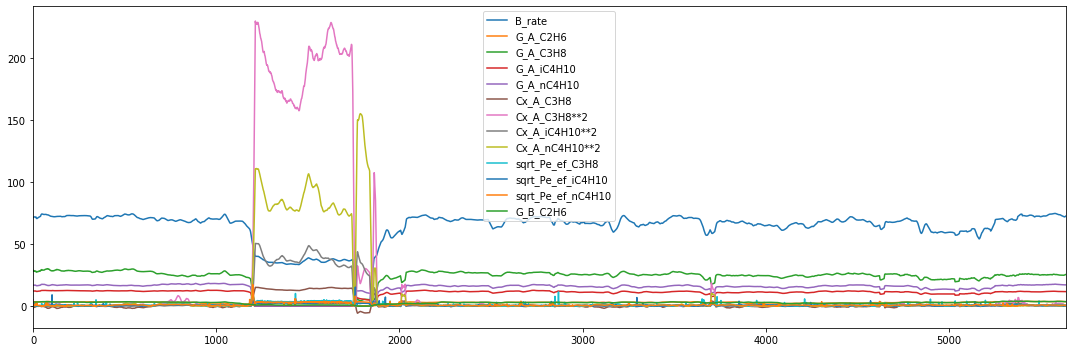

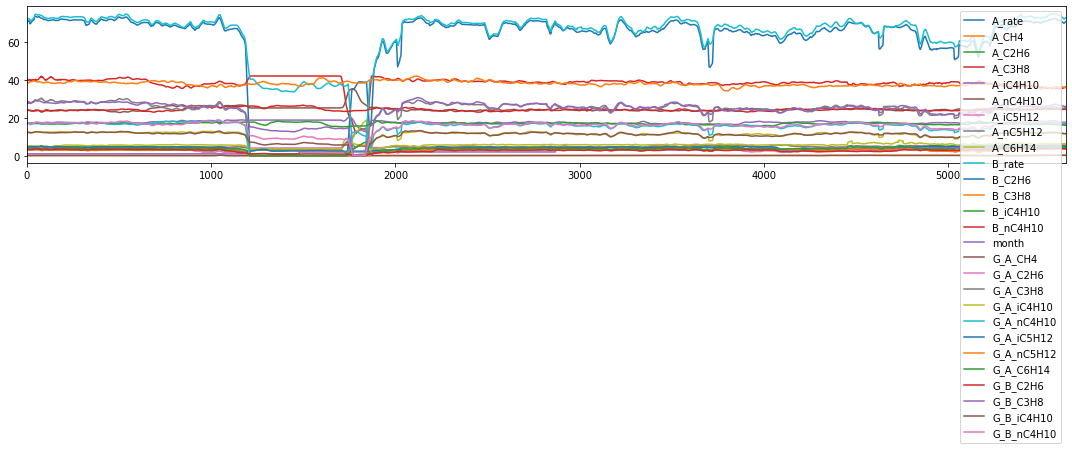

In [248]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
#d[:].plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [249]:
#запись DataFrame в файл
d.to_csv('train_data_C2H6.csv', sep=',', header=True, index=False)

In [250]:
corrMatrix[(corrMatrix['G_B_C3H8'] > 0.6) | (corrMatrix['G_B_C3H8'] < -0.6)][['x', 'G_B_C3H8']]

x  G_B_C3H8
0              A_rate  0.841558
2              A_C2H6  0.689469
5            A_nC4H10 -0.601301
9              B_rate  0.986679
12           G_A_C2H6  0.856869
13           G_A_C3H8  0.904781
14         G_A_iC4H10  0.851318
15         G_A_nC4H10  0.801233
20           mu_mix_A -0.684866
21                w_A  0.849749
22               Re_A  0.867334
23          A_rate**2  0.896373
24        sqrt_A_rate  0.775635
26          lg_A_rate  0.676012
27          ln_A_rate  0.676012
28          B_rate**2  0.964568
29        sqrt_B_rate  0.948656
31            Re_A**2  0.908180
32          sqrt_Re_A  0.800713
33            lg_Re_A  0.684688
34            ln_Re_A  0.684688
43             w_prev  0.850026
45       Cx_A_C3H8**2 -0.688292
46     Cx_A_iC4H10**2 -0.811543
47     Cx_A_nC4H10**2 -0.879473
60    sqrt_Pe_ef_C3H8 -0.641134
63  sqrt_Pe_ef_iC4H10 -0.710979
64    e**Pe_ef_iC4H10  0.666752
66  sqrt_Pe_ef_nC4H10 -0.711720

In [251]:
d = data[['B_rate','Re_A',
          'G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10',
          #'Cx_A_C2H6','Cx_A_C3H8','Cx_A_iC4H10','Cx_A_nC4H10',
          #'Cx_A_C2H6**2',
          'Cx_A_C3H8**2', 'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2',
          #'Pe_ef_C2H6','Pe_ef_C3H8','Pe_ef_iC4H10','Pe_ef_nC4H10',
          #'sqrt_Pe_ef_C2H6',
          'sqrt_Pe_ef_C3H8','sqrt_Pe_ef_iC4H10','sqrt_Pe_ef_nC4H10',
          'e**Pe_ef_iC4H10',
          'G_B_C3H8']]

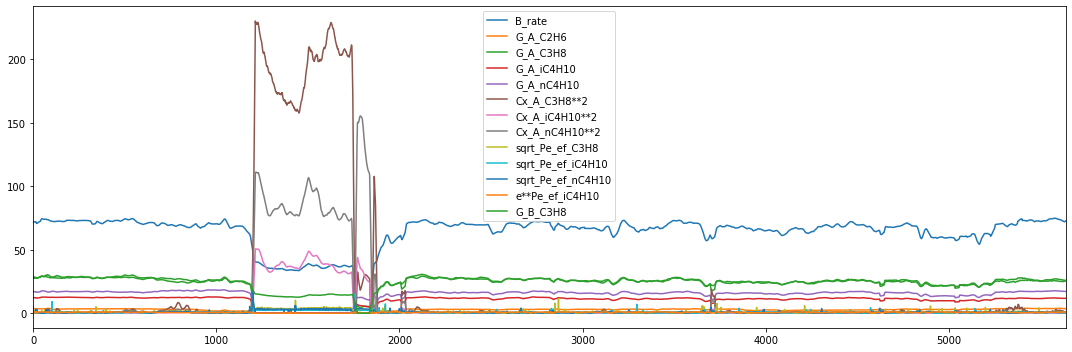

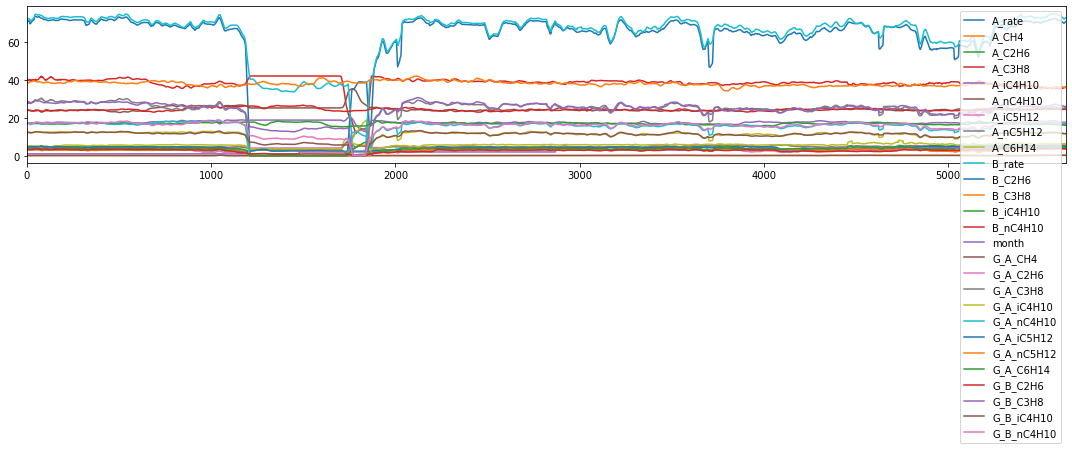

In [252]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
#d.plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [253]:
#запись DataFrame в файл
d.to_csv('train_data_C3H8.csv', sep=',', header=True, index=False)

In [254]:
corrMatrix[(corrMatrix['G_B_iC4H10'] > 0.6) | (corrMatrix['G_B_iC4H10'] < -0.6)][['x', 'G_B_iC4H10']]

x  G_B_iC4H10
0              A_rate    0.846426
2              A_C2H6    0.664891
9              B_rate    0.990286
12           G_A_C2H6    0.841372
13           G_A_C3H8    0.903690
14         G_A_iC4H10    0.857441
15         G_A_nC4H10    0.811777
18          G_A_C6H14    0.615268
20           mu_mix_A   -0.686442
21                w_A    0.853847
22               Re_A    0.871015
23          A_rate**2    0.899330
24        sqrt_A_rate    0.780742
26          lg_A_rate    0.681347
27          ln_A_rate    0.681347
28          B_rate**2    0.967513
29        sqrt_B_rate    0.951416
31            Re_A**2    0.908957
32          sqrt_Re_A    0.805288
33            lg_Re_A    0.690024
34            ln_Re_A    0.690024
43             w_prev    0.854313
45       Cx_A_C3H8**2   -0.697964
46     Cx_A_iC4H10**2   -0.809908
47     Cx_A_nC4H10**2   -0.879002
60    sqrt_Pe_ef_C3H8   -0.647281
63  sqrt_Pe_ef_iC4H10   -0.708737
64    e**Pe_ef_iC4H10    0.664789
66  sqrt_Pe_ef_nC4H10   -0.709314

In [255]:
d = data[['B_rate','Re_A',
          'G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10',
          #'Cx_A_C2H6','Cx_A_C3H8','Cx_A_iC4H10','Cx_A_nC4H10',
          #'Cx_A_C2H6**2',
          'Cx_A_C3H8**2', 'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2',
          #'Pe_ef_C2H6','Pe_ef_C3H8','Pe_ef_iC4H10','Pe_ef_nC4H10',
          #'sqrt_Pe_ef_C2H6',
          'sqrt_Pe_ef_C3H8','sqrt_Pe_ef_iC4H10','sqrt_Pe_ef_nC4H10',
          'e**Pe_ef_iC4H10',
          'G_B_iC4H10']]

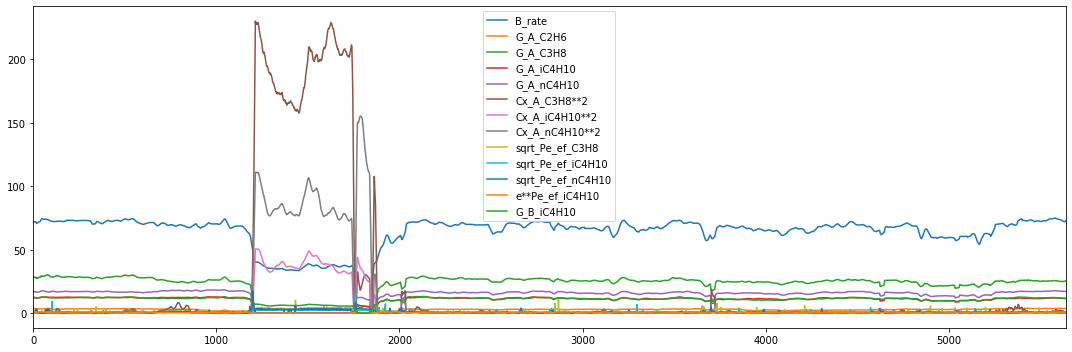

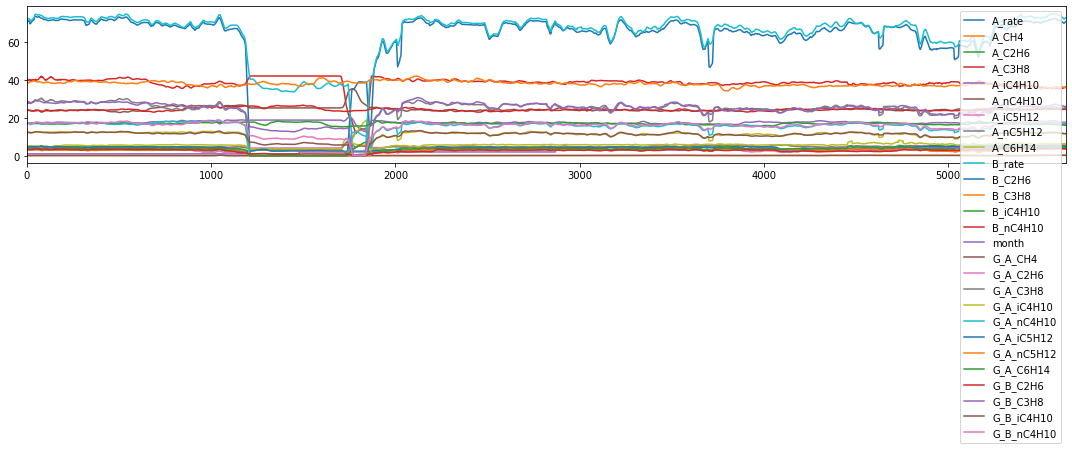

In [256]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
#d.plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [257]:
#запись DataFrame в файл
d.to_csv('train_data_iC4H10.csv', sep=',', header=True, index=False)

In [258]:
corrMatrix[(corrMatrix['G_B_nC4H10'] > 0.6) | (corrMatrix['G_B_nC4H10'] < -0.6)][['x','G_B_nC4H10']] 

x  G_B_nC4H10
0              A_rate    0.834171
2              A_C2H6    0.657132
9              B_rate    0.990994
12           G_A_C2H6    0.827510
13           G_A_C3H8    0.889742
14         G_A_iC4H10    0.845434
15         G_A_nC4H10    0.801338
18          G_A_C6H14    0.602485
20           mu_mix_A   -0.700103
21                w_A    0.841518
22               Re_A    0.860677
23          A_rate**2    0.887103
24        sqrt_A_rate    0.768264
26          lg_A_rate    0.668566
27          ln_A_rate    0.668566
28          B_rate**2    0.963252
29        sqrt_B_rate    0.958327
31            Re_A**2    0.899302
32          sqrt_Re_A    0.794035
33            lg_Re_A    0.677518
34            ln_Re_A    0.677518
43             w_prev    0.842036
45       Cx_A_C3H8**2   -0.685675
46     Cx_A_iC4H10**2   -0.803848
47     Cx_A_nC4H10**2   -0.877925
60    sqrt_Pe_ef_C3H8   -0.637340
63  sqrt_Pe_ef_iC4H10   -0.700456
64    e**Pe_ef_iC4H10    0.653170
66  sqrt_Pe_ef_nC4H10   -0.703430

In [259]:
d = data[['B_rate', 'Re_A',
          'G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10',
          #'Cx_A_C2H6','Cx_A_C3H8','Cx_A_iC4H10','Cx_A_nC4H10',
          #'Cx_A_C2H6**2',
          'Cx_A_C3H8**2', 'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2',
          #'Pe_ef_C2H6','Pe_ef_C3H8','Pe_ef_iC4H10','Pe_ef_nC4H10',
          #'sqrt_Pe_ef_C2H6',
          'sqrt_Pe_ef_C3H8','sqrt_Pe_ef_iC4H10','sqrt_Pe_ef_nC4H10',
          'e**Pe_ef_iC4H10',
          'G_B_nC4H10']]

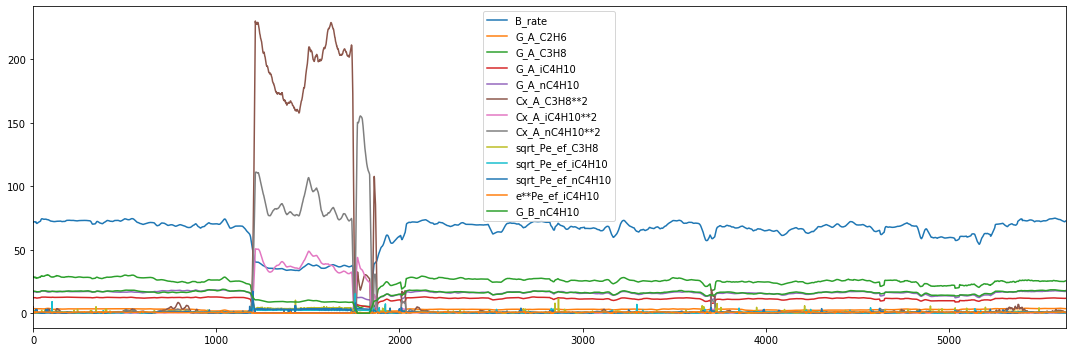

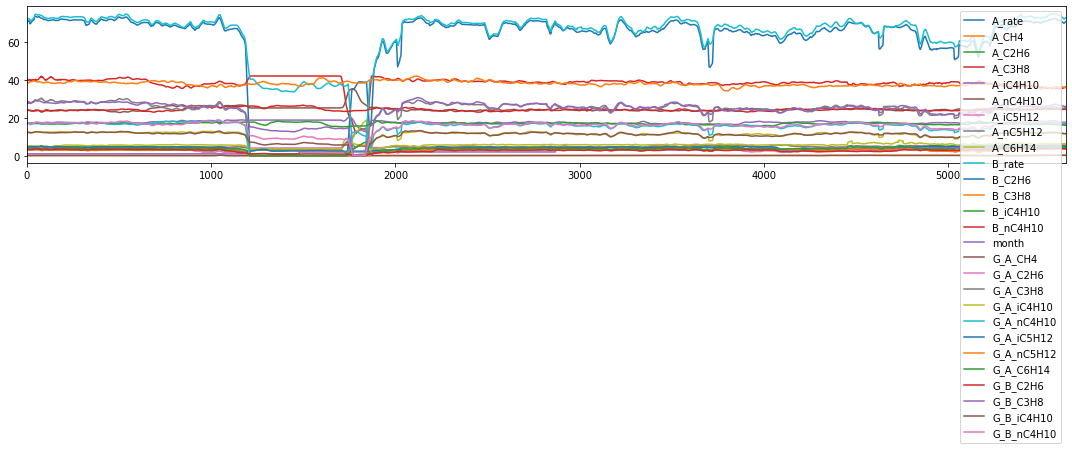

In [260]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
#d.plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [261]:
#запись DataFrame в файл
d.to_csv('train_data_nC4H10.csv', sep=',', header=True, index=False)

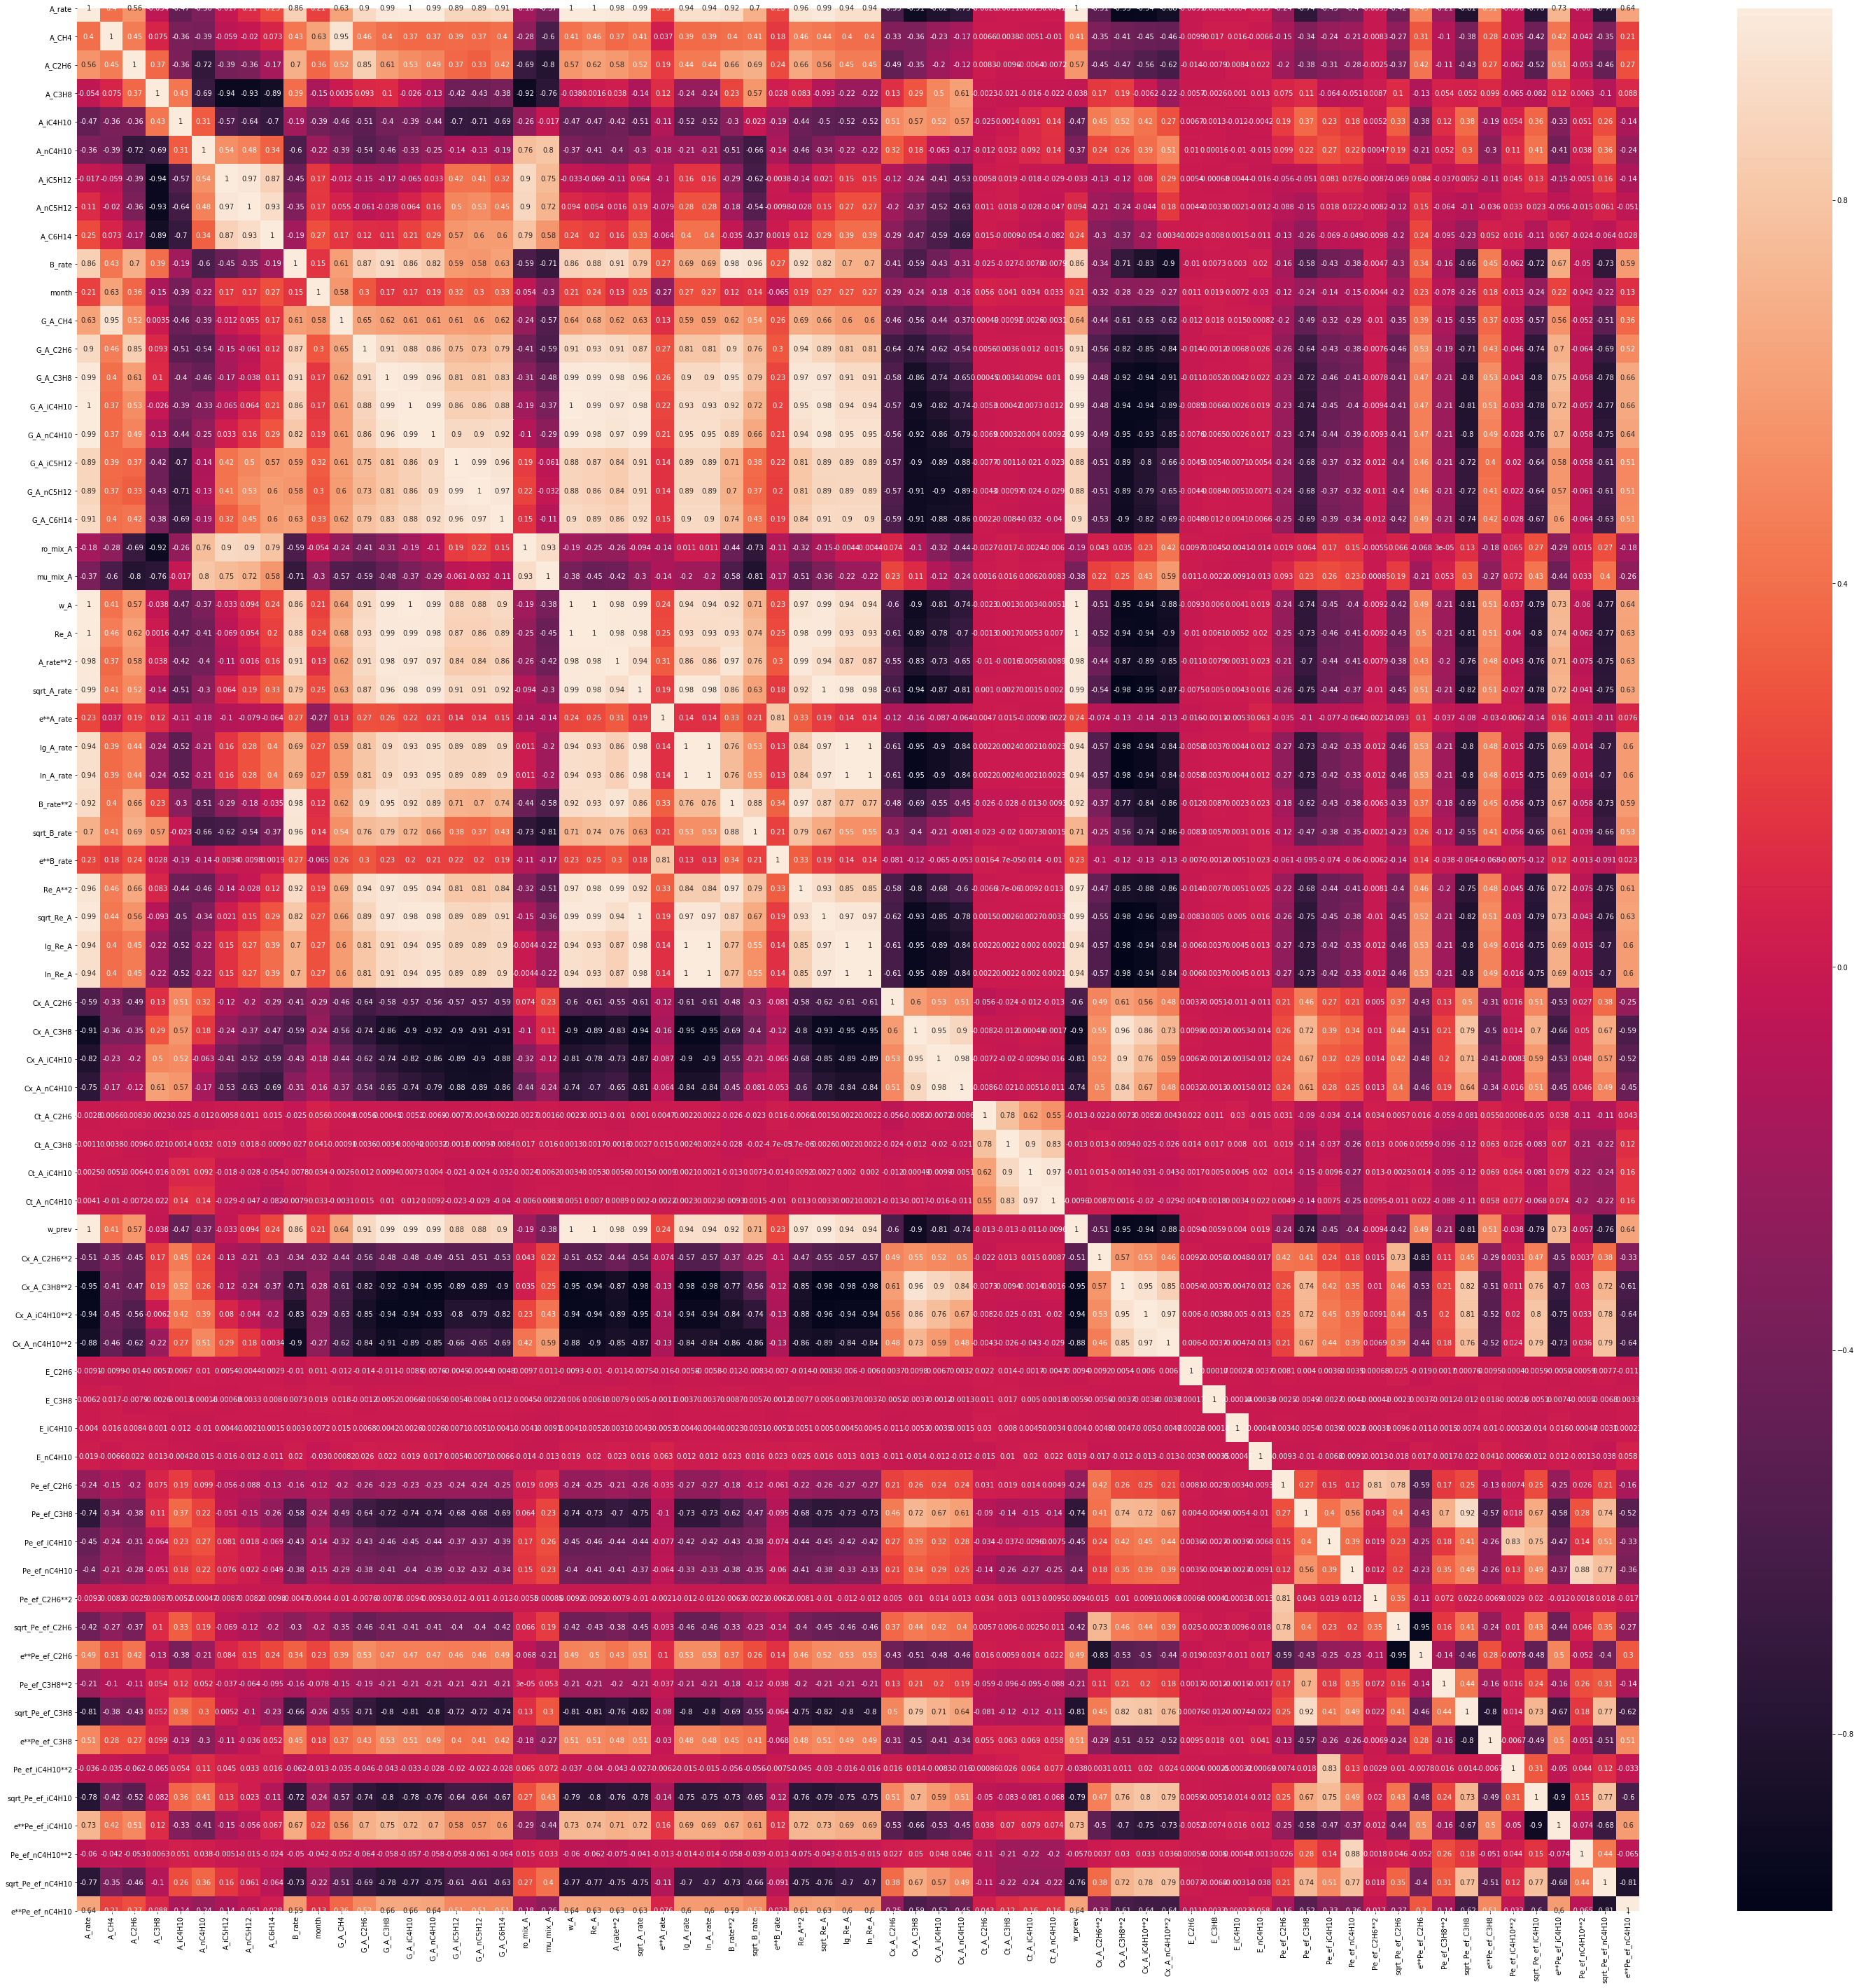

In [262]:
plt.figure(figsize=(50,50))
sns.heatmap(x.corr(), annot=True)

In [263]:
#запись DataFrame в файл
data.to_csv('train_data.csv', sep=',', header=True, index=False)

1. ГОСТ 28656-90
2. "Природные и искусственные газы. Учебник для техникумов. 4-е изд. 1978 г" Рябцев Н.И.
3. Wikipedia

In [264]:
#!cat train_data.csv

## Обработаем test_features

In [265]:
monthList =[]
for i in test_features['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [266]:
test_features['month'] = monthList

In [267]:
test_features = test_features.ffill(axis = 0)
test_features.isnull().sum()

timestamp    0
A_rate       0
A_CH4        0
A_C2H6       0
A_C3H8       0
A_iC4H10     0
A_nC4H10     0
A_iC5H12     0
A_nC5H12     0
A_C6H14      0
B_rate       0
month        0
dtype: int64

In [268]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480   
1     2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023   
2     2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965   
3     2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180   
4     2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587   
...                   ...        ...       ...       ...        ...   
3979  2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930   
3980  2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418   
3981  2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323   
3982  2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503   
3983  2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  month  
0     16.632260  24.062587  5.696004  4.939430  6.395286  74.273009      5  
1     16.651870  24.069800  5.676384  4.911872  6.346957  74.061833      5  
2     16.710967  24.106152  5.574873  4.808516  6.242636  73.856268      5  
3     16.683337  24.021993  5.514843  4.730887  6.101647  73.750744      5  
4     16.663863  24.003237  5.524898  4.728882  6.057119  73.698447      5  
...         ...        ...       ...       ...       ...        ...    ...  
3979  17.741460  24.098520  4.469224  3.619095  4.686205  75.486026      7  
3980  17.449352  24.049532  4.770699  3.988215  6.689777  75.370451      7  
3981  17.635380  24.169473  4.613603  3.790651  5.785216  74.985878      7  
3982  17.758833  24.211013  4.504242  3.657459  5.094626  74.766867      7  
3983  17.772225  24.088445  4.387957  3.536302  4.863965  74.804667      7  

[3984 rows x 12 columns]

In [269]:
test_features_prev = test_features
test_features = test_features.rolling(25, min_periods=0).mean()

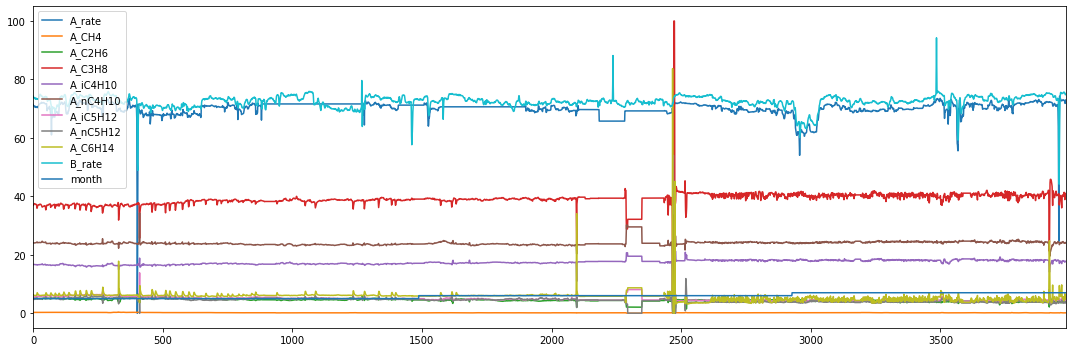

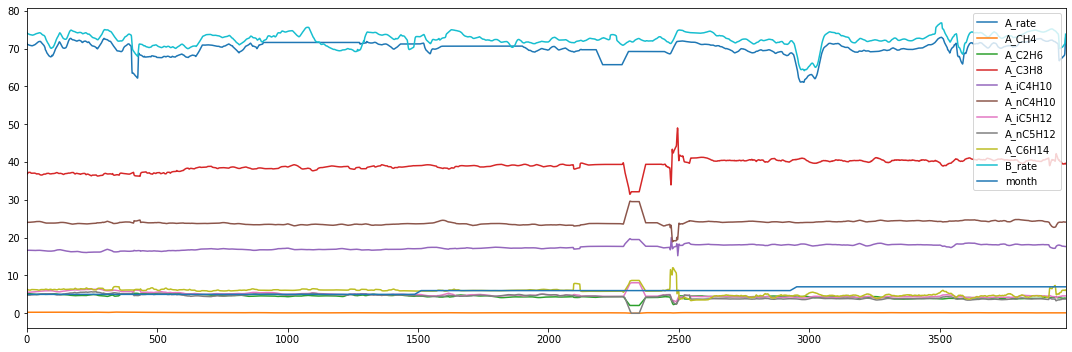

In [270]:
plt.rcParams["figure.figsize"] = (15,5)
test_features_prev[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
test_features[:].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [271]:
test_features['timestamp'] = test_features_prev['timestamp']

In [272]:
test_features['G_A_CH4'] = test_features['A_rate'] * test_features['A_CH4'] / 100
test_features['G_A_C2H6'] = test_features['A_rate'] * test_features['A_C2H6'] / 100
test_features['G_A_C3H8'] = test_features['A_rate'] * test_features['A_C3H8'] / 100
test_features['G_A_iC4H10'] = test_features['A_rate'] * test_features['A_iC4H10'] / 100
test_features['G_A_nC4H10'] = test_features['A_rate'] * test_features['A_nC4H10'] / 100
test_features['G_A_iC5H12'] = test_features['A_rate'] * test_features['A_iC5H12'] / 100
test_features['G_A_nC5H12'] = test_features['A_rate'] * test_features['A_nC5H12'] / 100
test_features['G_A_C6H14'] = test_features['A_rate'] * test_features['A_C6H14'] / 100

In [273]:
test_features['ro_mix_A'] = ((test_features['A_CH4'] / 100 / ro_CH4) + (test_features['A_C2H6'] / 100 / ro_C2H6) 
                  + (test_features['A_C3H8'] / 100 / ro_C3H8) + (test_features['A_iC4H10'] / 100 / ro_iC4H10) 
                  + (test_features['A_nC4H10'] / 100 / ro_nC4H10) + (test_features['A_iC5H12'] / 100 / ro_iC5H12)
                  + (test_features['A_nC5H12'] / 100 / ro_nC5H12) + (test_features['A_C6H14'] / 100 / ro_C6H14))**-1

In [274]:
test_features['mu_mix_A'] = (((test_features['A_CH4'] / 100) * (test_features['ro_mix_A'] / ro_CH4)) / mu_CH4 
                  + ((test_features['A_C2H6'] / 100) * (test_features['ro_mix_A'] / ro_C2H6)) / mu_C2H6 
                  + ((test_features['A_C3H8'] / 100) * (test_features['ro_mix_A'] / ro_C3H8)) / mu_C3H8
                  + ((test_features['A_iC4H10'] / 100) * (test_features['ro_mix_A'] / ro_iC4H10)) / mu_iC4H10
                  + ((test_features['A_nC4H10'] / 100) * (test_features['ro_mix_A'] / ro_nC4H10)) / mu_nC4H10
                  + ((test_features['A_iC5H12'] / 100) * (test_features['ro_mix_A'] / ro_iC5H12)) / mu_iC5H12
                  + ((test_features['A_nC5H12'] / 100) * (test_features['ro_mix_A'] / ro_nC5H12)) / mu_nC5H12
                  + ((test_features['A_C6H14'] / 100) * (test_features['ro_mix_A'] / ro_C6H14)) / mu_C6H14)**-1

In [275]:
test_features['w_A'] = (4*test_features['A_rate']*0.278)/(3.14*test_features['ro_mix_A']*0.16)
test_features['Re_A'] = (4*test_features['A_rate']*0.278)/(3.14*0.4*test_features['mu_mix_A'])

In [276]:
test_features['A_rate**2'] = test_features['A_rate']**2
test_features['sqrt_A_rate'] = test_features['A_rate'].apply(m.sqrt)
test_features['e**A_rate'] = test_features['A_rate'].apply(m.exp)
test_features['lg_A_rate'] = test_features['A_rate'].apply(m.log10)
test_features['ln_A_rate'] = test_features['A_rate'].apply(m.log)

test_features['B_rate**2'] = test_features['B_rate']**2
test_features['sqrt_B_rate'] = test_features['B_rate'].apply(m.sqrt)
test_features['e**B_rate'] = test_features['B_rate'].apply(m.exp)


test_features['Re_A**2'] = test_features['Re_A']**2
test_features['sqrt_Re_A'] = test_features['Re_A'].apply(m.sqrt)

test_features['lg_Re_A'] = test_features['Re_A'].apply(m.log10)
test_features['ln_Re_A'] = test_features['Re_A'].apply(m.log)

In [277]:
test_features

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.428342  0.267832  5.135159  36.816480  16.632260  24.062587   
1     71.176730  0.268148  5.142402  36.842752  16.642065  24.066193   
2     71.115060  0.268979  5.146473  36.920156  16.665032  24.079513   
3     71.079396  0.270545  5.167520  37.036162  16.669608  24.065133   
4     71.059532  0.271448  5.182303  37.118647  16.668459  24.052754   
...         ...       ...       ...        ...        ...        ...   
3979  68.304891  0.119512  4.025974  39.598743  17.690124  24.125104   
3980  68.632519  0.119121  4.015950  39.536427  17.662900  24.111860   
3981  69.834182  0.118976  4.002939  39.496366  17.645730  24.110723   
3982  71.735081  0.119308  3.991399  39.479565  17.635418  24.113394   
3983  72.741092  0.120283  3.998443  39.627151  17.650079  24.115738   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate  month            timestamp  \
0     5.696004  4.939430  6.395286  74.273009    5.0  2020-05-01 00:00:00   
1     5.686194  4.925651  6.371121  74.167421    5.0  2020-05-01 00:30:00   
2     5.649087  4.886606  6.328293  74.063703    5.0  2020-05-01 01:00:00   
3     5.615526  4.847676  6.271631  73.985463    5.0  2020-05-01 01:30:00   
4     5.597400  4.823918  6.228729  73.928060    5.0  2020-05-01 02:00:00   
...        ...       ...       ...        ...    ...                  ...   
3979  4.584583  3.754411  6.050439  71.147451    7.0  2020-07-22 21:30:00   
3980  4.598629  3.773469  6.130404  71.256112    7.0  2020-07-22 22:00:00   
3981  4.610501  3.788795  6.174530  71.607384    7.0  2020-07-22 22:30:00   
3982  4.617921  3.798771  6.192439  72.582642    7.0  2020-07-22 23:00:00   
3983  4.596188  3.772929  6.066762  73.808644    7.0  2020-07-22 23:30:00   

       G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  \
0     0.191308  3.667959  26.297401   11.880148   17.187507    4.068561   
1     0.190859  3.660194  26.223466   11.845278   17.129529    4.047247   
2     0.191285  3.659918  26.255791   11.851348   17.124160    4.017352   
3     0.192301  3.673042  26.325080   11.848657   17.105351    3.991482   
4     0.192890  3.682521  26.376337   11.844529   17.091774    3.977487   
...        ...       ...        ...         ...         ...         ...   
3979  0.081633  2.749937  27.047878   12.083220   16.478626    3.131494   
3980  0.081756  2.756247  27.134846   12.122493   16.548577    3.156155   
3981  0.083086  2.795420  27.581964   12.322751   16.837526    3.219705   
3982  0.085586  2.863233  28.320698   12.650781   17.297763    3.312669   
3983  0.087495  2.908511  28.825223   12.838860   17.542051    3.343317   

      G_A_nC5H12  G_A_C6H14    ro_mix_A  mu_mix_A       w_A           Re_A  \
0       3.528153   4.568047  562.574167  0.000151  0.281026  419019.690291   
1       3.505918   4.534756  562.513894  0.000151  0.280066  417716.031332   
2       3.475113   4.500369  562.390951  0.000151  0.279884  417677.086653   
3       3.445699   4.457838  562.189616  0.000151  0.279844  418092.480177   
4       3.427853   4.426106  562.050079  0.000150  0.279835  418391.849005   
...          ...        ...         ...       ...       ...            ...   
3979    2.564446   4.132746  563.020705  0.000159  0.268524  380844.777764   
3980    2.589827   4.207451  563.157117  0.000159  0.269746  382368.259444   
3981    2.645874   4.311932  563.259337  0.000159  0.274419  388821.338979   
3982    2.725052   4.442151  563.319351  0.000159  0.281859  399288.163412   
3983    2.744470   4.413029  563.101145  0.000159  0.285923  405435.375734   

        A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate  \
0     5102.008078     8.451529  1.049385e+31   1.853871   4.268695   
1     5066.126880     8.436630  8.159453e+30   1.852338   4.265166   
2     5057.351702     8.432975  7.671459e+30   1.851962   4.264299   
3     5052.280554     8.430860  7.402689e+30   1.851744   4.263798   
4     5049.457156     8.429682 

In [278]:
last_line

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
5637  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
5637  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10            timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  \
5637  24.517125  2020-04-30 23:30:00      4  0.213048  3.569881  25.479712   

      G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6  \
5637   11.724163   17.183164    4.152003    3.661481   4.466263  3.648088   

       G_B_C3H8  G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A  \
5637  25.981607   11.638576   17.799919  563.169703   0.00015  0.277036   

               Re_A    A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  \
5637  415477.749614  4968.683371     8.395766  4.101429e+30   1.848121   

      ln_A_rate    B_rate**2  sqrt_B_rate     e**B_rate       Re_A**2  \
5637   4.255455  5271.047629      8.52068  3.393436e+31  1.726218e+11   

       sqrt_Re_A   lg_Re_A    ln_Re_A  Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  \
5637  644.575635  5.618548  12.937184   0.068488   0.526622    -0.091283   

      Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10    w_prev  \
5637     0.596711  -0.000561   0.055675      0.01638     0.016305  0.276608   

      Cx_A_C2H6**2  Cx_A_C3H8**2  Cx_A_iC4H10**2  Cx_A_nC4H10**2    E_C2H6  \
5637      0.004691      0.277331        0.008333        0.356064  3.919092   

        E_C3H8  E_iC4H10  E_nC4H10  Pe_ef_C2H6  Pe_ef_C3H8  Pe_ef_iC4H10  \
5637  0.726001 -1.064438  0.509348     0.07058    0.381002      0.259863   

      Pe_ef_nC4H10  Pe_ef_C2H6**2  sqrt_Pe_ef_C2H6  e**Pe_ef_C2H6  \
5637      0.543063       0.004981         0.265668       0.931854   

      Pe_ef_C3H8**2  sqrt_Pe_ef_C3H8  e**Pe_ef_C3H8  Pe_ef_iC4H10**2  \
5637       0.145163         0.617254       0.683176         0.067529   

      sqrt_Pe_ef_iC4H10  e**Pe_ef_iC4H10  Pe_ef_nC4H10**2  sqrt_Pe_ef_nC4H10  \
5637           0.509768         0.771157         0.294918           0.736928   

      e**Pe_ef_nC4H10  
5637         0.580966

In [279]:
test_features = pd.concat([last_line,test_features], axis=0)
test_features = test_features.reset_index(drop=True)

In [280]:
test_features

A_C2H6     A_C3H8   A_C6H14     A_CH4   A_iC4H10  A_iC5H12   A_nC4H10  \
0     5.064459  36.147132  6.336124  0.302244  16.632641  5.890294  24.377125   
1     5.135159  36.816480  6.395286  0.267832  16.632260  5.696004  24.062587   
2     5.142402  36.842752  6.371121  0.268148  16.642065  5.686194  24.066193   
3     5.146473  36.920156  6.328293  0.268979  16.665032  5.649087  24.079513   
4     5.167520  37.036162  6.271631  0.270545  16.669608  5.615526  24.065133   
...        ...        ...       ...       ...        ...       ...        ...   
3980  4.025974  39.598743  6.050439  0.119512  17.690124  4.584583  24.125104   
3981  4.015950  39.536427  6.130404  0.119121  17.662900  4.598629  24.111860   
3982  4.002939  39.496366  6.174530  0.118976  17.645730  4.610501  24.110723   
3983  3.991399  39.479565  6.192439  0.119308  17.635418  4.617921  24.113394   
3984  3.998443  39.627151  6.066762  0.120283  17.650079  4.596188  24.115738   

      A_nC5H12     A_rate    A_rate**2    B_C2H6     B_C3H8   B_iC4H10  \
0     5.194408  70.488888  4968.683371  5.024778  35.786361  16.030659   
1     4.939430  71.428342  5102.008078       NaN        NaN        NaN   
2     4.925651  71.176730  5066.126880       NaN        NaN        NaN   
3     4.886606  71.115060  5057.351702       NaN        NaN        NaN   
4     4.847676  71.079396  5052.280554       NaN        NaN        NaN   
...        ...        ...          ...       ...        ...        ...   
3980  3.754411  68.304891  4665.558100       NaN        NaN        NaN   
3981  3.773469  68.632519  4710.422705       NaN        NaN        NaN   
3982  3.788795  69.834182  4876.812974       NaN        NaN        NaN   
3983  3.798771  71.735081  5145.921826       NaN        NaN        NaN   
3984  3.772929  72.741092  5291.266535       NaN        NaN        NaN   

       B_nC4H10     B_rate    B_rate**2  Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  \
0     24.517125  72.601981  5271.047629  -0.000561   0.055675      0.01638   
1           NaN  74.273009  5516.479837        NaN        NaN          NaN   
2           NaN  74.167421  5500.806318        NaN        NaN          NaN   
3           NaN  74.063703  5485.432125        NaN        NaN          NaN   
4           NaN  73.985463  5473.848776        NaN        NaN          NaN   
...         ...        ...          ...        ...        ...          ...   
3980        NaN  71.147451  5061.959773        NaN        NaN          NaN   
3981        NaN  71.256112  5077.433495        NaN        NaN          NaN   
3982        NaN  71.607384  5127.617512        NaN        NaN          NaN   
3983        NaN  72.582642  5268.239886        NaN        NaN          NaN   
3984        NaN  73.808644  5447.715933        NaN        NaN          NaN   

      Ct_A_nC4H10  Cx_A_C2H6  Cx_A_C2H6**2  Cx_A_C3H8  Cx_A_C3H8**2  \
0        0.016305   0.068488      0.004691   0.526622      0.277331   
1             NaN        NaN           NaN        NaN           NaN   
2             NaN        NaN           NaN        NaN           NaN   
3             NaN        NaN           NaN        NaN           NaN   
4             NaN        NaN           NaN        NaN           NaN   
...           ...        ...           ...        ...           ...   
3980          NaN        NaN           NaN        NaN           NaN   
3981          NaN        NaN           NaN        NaN           NaN   
3982          NaN        NaN           NaN        NaN           NaN   
3983          NaN        NaN           NaN        NaN           NaN   
3984          NaN        NaN           NaN        NaN           NaN   

      Cx_A_iC4H10  Cx_A_iC4H10**2  Cx_A_nC4H10  Cx_A_nC4H10**2    E_C2H6  \
0       -0.091283        0.008333     0.596711        0.356064  3.919092   
1             NaN             NaN          NaN             NaN       NaN   
2             NaN             NaN          NaN             NaN       NaN   
3             NaN             NaN          NaN      

In [281]:
test_features.columns

Index(['A_C2H6', 'A_C3H8', 'A_C6H14', 'A_CH4', 'A_iC4H10', 'A_iC5H12',
       'A_nC4H10', 'A_nC5H12', 'A_rate', 'A_rate**2', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'B_rate', 'B_rate**2', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'Cx_A_C2H6', 'Cx_A_C2H6**2', 'Cx_A_C3H8',
       'Cx_A_C3H8**2', 'Cx_A_iC4H10', 'Cx_A_iC4H10**2', 'Cx_A_nC4H10',
       'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10', 'E_nC4H10',
       'G_A_C2H6', 'G_A_C3H8', 'G_A_C6H14', 'G_A_CH4', 'G_A_iC4H10',
       'G_A_iC5H12', 'G_A_nC4H10', 'G_A_nC5H12', 'G_B_C2H6', 'G_B_C3H8',
       'G_B_iC4H10', 'G_B_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C2H6**2', 'Pe_ef_C3H8',
       'Pe_ef_C3H8**2', 'Pe_ef_iC4H10', 'Pe_ef_iC4H10**2', 'Pe_ef_nC4H10',
       'Pe_ef_nC4H10**2', 'Re_A', 'Re_A**2', 'e**A_rate', 'e**B_rate',
       'e**Pe_ef_C2H6', 'e**Pe_ef_C3H8', 'e**Pe_ef_iC4H10', 'e**Pe_ef_nC4H10',
       'lg_A_rate', 'lg_Re_A', 'ln_A_rate', 'ln_Re_A', 'month', 'mu_mix_A',
       'ro_mix_A', 'sqrt_A_rate',

In [282]:
test_features = test_features.drop(labels=['A_C2H6', 'A_C3H8', 'A_C6H14', 'A_CH4', 'A_iC4H10', 'A_iC5H12',
                                           'A_nC4H10', 'A_nC5H12', 'A_rate', 'A_rate**2', 'B_C2H6', 'B_C3H8',
                                           'B_iC4H10', 'B_nC4H10', 'B_rate**2', 'Ct_A_C2H6', 'Ct_A_C3H8',
                                           'Ct_A_iC4H10', 'Ct_A_nC4H10', 'E_C2H6', 'E_C3H8', 'E_iC4H10', 'E_nC4H10',
                                           'Re_A**2', 'e**A_rate', 'e**B_rate','lg_A_rate', 'lg_Re_A', 'ln_A_rate', 
                                           'ln_Re_A', 'month', 'mu_mix_A','ro_mix_A', 'sqrt_A_rate', 'sqrt_B_rate',
                                           'sqrt_Re_A'],axis=1)

In [283]:
test_features

B_rate  Cx_A_C2H6  Cx_A_C2H6**2  Cx_A_C3H8  Cx_A_C3H8**2  \
0     72.601981   0.068488      0.004691   0.526622      0.277331   
1     74.273009        NaN           NaN        NaN           NaN   
2     74.167421        NaN           NaN        NaN           NaN   
3     74.063703        NaN           NaN        NaN           NaN   
4     73.985463        NaN           NaN        NaN           NaN   
...         ...        ...           ...        ...           ...   
3980  71.147451        NaN           NaN        NaN           NaN   
3981  71.256112        NaN           NaN        NaN           NaN   
3982  71.607384        NaN           NaN        NaN           NaN   
3983  72.582642        NaN           NaN        NaN           NaN   
3984  73.808644        NaN           NaN        NaN           NaN   

      Cx_A_iC4H10  Cx_A_iC4H10**2  Cx_A_nC4H10  Cx_A_nC4H10**2  G_A_C2H6  \
0       -0.091283        0.008333     0.596711        0.356064  3.569881   
1             NaN             NaN          NaN             NaN  3.667959   
2             NaN             NaN          NaN             NaN  3.660194   
3             NaN             NaN          NaN             NaN  3.659918   
4             NaN             NaN          NaN             NaN  3.673042   
...           ...             ...          ...             ...       ...   
3980          NaN             NaN          NaN             NaN  2.749937   
3981          NaN             NaN          NaN             NaN  2.756247   
3982          NaN             NaN          NaN             NaN  2.795420   
3983          NaN             NaN          NaN             NaN  2.863233   
3984          NaN             NaN          NaN             NaN  2.908511   

       G_A_C3H8  G_A_C6H14   G_A_CH4  G_A_iC4H10  G_A_iC5H12  G_A_nC4H10  \
0     25.479712   4.466263  0.213048   11.724163    4.152003   17.183164   
1     26.297401   4.568047  0.191308   11.880148    4.068561   17.187507   
2     26.223466   4.534756  0.190859   11.845278    4.047247   17.129529   
3     26.255791   4.500369  0.191285   11.851348    4.017352   17.124160   
4     26.325080   4.457838  0.192301   11.848657    3.991482   17.105351   
...         ...        ...       ...         ...         ...         ...   
3980  27.047878   4.132746  0.081633   12.083220    3.131494   16.478626   
3981  27.134846   4.207451  0.081756   12.122493    3.156155   16.548577   
3982  27.581964   4.311932  0.083086   12.322751    3.219705   16.837526   
3983  28.320698   4.442151  0.085586   12.650781    3.312669   17.297763   
3984  28.825223   4.413029  0.087495   12.838860    3.343317   17.542051   

      G_A_nC5H12  G_B_C2H6   G_B_C3H8  G_B_iC4H10  G_B_nC4H10  Pe_ef_C2H6  \
0       3.661481  3.648088  25.981607   11.638576   17.799919     0.07058   
1       3.528153       NaN        NaN         NaN         NaN         NaN   
2       3.505918       NaN        NaN         NaN         NaN         NaN   
3       3.475113       NaN        NaN         NaN         NaN         NaN   
4       3.445699       NaN        NaN         NaN         NaN         NaN   
...          ...       ...        ...         ...         ...         ...   
3980    2.564446       NaN        NaN         NaN         NaN         NaN   
3981    2.589827       NaN        NaN         NaN         NaN         NaN   
3982    2.645874       NaN        NaN         NaN         NaN         NaN   
3983    2.725052       NaN        NaN         NaN         NaN         NaN   
3984    2.744470       NaN        NaN         NaN         NaN         NaN   

      Pe_ef_C2H6**2  Pe_ef_C3H8  Pe_ef_C3H8**2  Pe_ef_iC4H10  Pe_ef_iC4H10**2  \
0          0.004981    0.381002       0.145163      0.259863         0.067529   
1               NaN         NaN            NaN           NaN              NaN   
2               NaN         NaN            NaN           NaN              NaN   
3               NaN         NaN            NaN           NaN              NaN   
4               NaN     

In [284]:
#запись DataFrame в файл
test_features.to_csv('test_data.csv', sep=',', header=True, index=False)